# examine performance of `gallery2` models in comparison to hybrid models
 * using all data for training
 * similar results for `m9` and `m5-m9` hybrid are due to a `xir` estimate close to zero and hence little size-dependence of respiration for `m9`
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# create plots of the data
show_data = False

# load data
datafiles = {
    #'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
for dataname in datafiles:

    if 'seaflow' in dataname:
        # Extract SeaFlow cell counts
        seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
        seaflow_counts = seaflow.values[:, 2:].T.astype(int)

        # Redefine parameters to match 32-size class count data. We only keep PAR from the 25-size class data.
        data_gridded[dataname]['m'] = seaflow_counts.shape[0]
        data_gridded[dataname]['size_bounds'] = seaflow.columns[2:].values.astype(float) # extract size classes from dataframe
        data_gridded[dataname]['v_min'] = data_gridded[dataname]['size_bounds'][0] # note these seem to be on a different scale
        data_gridded[dataname]['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded[dataname]['size_bounds'][1]/data_gridded[dataname]['size_bounds'][0])))
        data_gridded[dataname]['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
        data_gridded[dataname]['counts'] = seaflow_counts
        data_gridded[dataname]['obs_time'] = np.empty(shape=seaflow_counts.shape[1])

        # Extract time stamps for each observation from SeaFlow data
        ii = 0
        for timestamp in np.asarray(seaflow['time'], dtype=str):
            datetime = dateutil.parser.isoparse(timestamp)
            if ii == 0:
                initial = datetime
            data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
            ii += 1

    elif 'zinser' in dataname:

        # Extract Zinser cell counts
        zinser = pd.read_csv('data/Zinser_Figure2A.csv')
        #zinser_counts = zinser.values[:,1].astype(int) # cells A column
        #zinser_counts = zinser.values[:,2].astype(int) # cells B column
        zinser_counts = np.mean(zinser.values, axis=1).astype(int) # mean of both columns
        
        # Add counts to Zinser data
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['w_obs'] * zinser_counts).astype(int)
        data_gridded[dataname]['obs_time'] = data_gridded[dataname]['time']

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3
        sharex = np.array_equal(data_gridded[dataname]['time'], data_gridded[dataname]['obs_time'])

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=sharex, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['counts'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
                
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    # load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    ## remove last index, so that dimensions agree
    #data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # switch on or off data fitting
    data[dataname]['prior_only'] = 0
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

In [4]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs_count'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [5]:
import pystan
import re

desc_model = {
    #'m1':'m1',
    #'m2':'m2',
    #'m3':'m3',
    'm4':'m4',
    'm5':'m5',
    'm6':'m6',
    'm7':'m7',
    'm8':'m8',
    'm9':'m9',
    'm10':'m10',
    'm11':'m5-m6 hybrid',
    'm12':'m5-m7 hybrid',
    'm13':'m5-m8 hybrid',
    'm14':'m5-m9 hybrid',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c56',
    'm12':'c57',
    'm13':'c58',
    'm14':'c59',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
    'c56':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c57':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
    'c58':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c59':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

/home/paul/.local/lib/python3.6/site-packages/Cython/Distutils/old_build_ext.py:41: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m4 NOW.


m4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5 NOW.


m5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6 NOW.


m6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m7 NOW.


m7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m8 NOW.


m8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m9 NOW.


m9: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m10 NOW.


m10: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m11 NOW.


m11: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m12 NOW.


m12: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m13 NOW.


m13: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m14 NOW.


m14: compiling


In [7]:
import time

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

try_again = False
refit_all = False

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    if model not in sampling_time:
        sampling_time[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if dataname not in sampling_time[model]:
            sampling_time[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    continue
        else:
            mcmcs[model] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000)
            sampling_time[model][dataname].append(time.time() - t0) # in seconds
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(model,itry+1,rhat_max))
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m4: in try 1/3 found Rhat=11.474, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m4 (m4)
Inference for Stan model: m4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          44.29    0.13    6.0  34.01  40.07  43.75   47.9  57.56   2077    1.0
gamma_max            8.0    0.01   0.63   6.52   7.61   8.16   8.52   8.79   1829    1.0
rho_max             1.28  9.6e-4   0.06   1.17   1.24   1.28   1.31   1.38   3359    1.0
E_star            221.56    0.74  31.34 148.95 202.67 227.65  244.9  268.6   1794    1.0
sigma             311.24     0.3  17.83  277.0 298.86 311.21  323.4 346.32   3569    1.0
divrate             0.86  6.9e-4   0.05   0.77   0.83   0.86   0.89   0.95   4671    1.0
delta[1]          6.2e-3  7.4e-5 6.0e-3 1.8e-4 1.9e-3 4.3e-3 8.7e-3   0.02   6584    1.0
delta[2]            0.01  1.1e-4 8.5e-3 1.8e-3 6.4e-3   0.01   0.02   0.03   5617    1.0
delta[3]            0.02  1.5e-4   0.01 4.6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m5: in try 1/3 found Rhat=7.202, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m5 (m5)
Inference for Stan model: m5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          23.51    0.12   5.24  15.97   20.1  22.69  25.81  36.74   2056    1.0
gamma_max           4.45  5.4e-3   0.31   4.06   4.25   4.39   4.57   5.22   3176    1.0
rho_max             1.56  9.4e-4   0.06   1.44   1.52   1.56   1.61   1.69   4481    1.0
E_star             85.99    0.36  21.99  53.88  71.38   82.5  96.92  140.3   3631    1.0
sigma             393.25    0.39  22.35 350.18 378.19 392.68 408.53 438.59   3296    1.0
divrate             0.61  7.4e-4   0.04   0.53   0.58   0.61   0.64    0.7   3518    1.0
delta[1]          8.5e-3  9.8e-5 7.4e-3 2.6e-4 2.8e-3 6.5e-3   0.01   0.03   5659    1.0
delta[2]            0.02  1.4e-4   0.01 2.5e-3 9.6e-3   0.02   0.02   0.04   5141    1.0
delta[3]            0.03  1.7e-4   0.01 7.2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m6: in try 1/3 found Rhat=4.878, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m6 (m6)
Inference for Stan model: m6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max            2.7  6.5e-3   0.41    2.0   2.42   2.67   2.95   3.65   4020    1.0
gamma_max           5.28  3.6e-3   0.21   4.95   5.14   5.26   5.39   5.77   3261    1.0
rho_max             2.09  1.2e-3   0.08   1.93   2.03   2.09   2.14   2.24   4649    1.0
E_star             80.08    0.21  12.29  61.28  71.91  78.62  86.13 108.85   3316    1.0
sigma             625.92     0.6  38.52 554.46 599.39 625.42 651.22 702.97   4070    1.0
xi                 -1.16  1.2e-3   0.08  -1.31  -1.21  -1.16   -1.1   -1.0   4349    1.0
xir                 0.49  1.1e-3   0.08   0.33   0.43   0.49   0.54   0.65   5357    1.0
divrate             0.33  4.5e-4   0.03   0.28   0.32   0.33   0.35   0.39   3623    1.0
delta[1]            0.02  2.5e-4   0.02 5.7

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m7 (m7)
Inference for Stan model: m7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           37.1    0.14    6.1  26.82  32.95   36.5  40.59  50.42   1873    1.0
gamma_max           8.15    0.01   0.52   6.88   7.84   8.26   8.57    8.8   2372    1.0
rho_max              1.5  1.5e-3   0.09   1.34   1.44    1.5   1.56   1.68   3423    1.0
E_star            193.37    0.48   24.8 136.59 178.23 197.13 211.41 233.03   2641    1.0
sigma             343.04    0.39   20.8 304.56 328.06  342.8  356.9 385.32   2833    1.0
xi                 -0.55  1.8e-3   0.11  -0.76  -0.62  -0.55  -0.48  -0.34   3324    1.0
xir                 0.26  1.6e-3    0.1   0.07    0.2   0.26   0.33   0.46   4000    1.0
divrate             0.73  8.3e-4   0.05   0.63   0.69   0.73   0.76   0.83   3759    1.0
delta[1]          7.2e-3  1.0e-4 6.9e-3 2.3

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m8 (m8)
Inference for Stan model: m8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           5.67  9.6e-3   0.52   4.78   5.32   5.63   5.98   6.84   2942    1.0
gamma_max           3.83  3.0e-3   0.12   3.63   3.75   3.82    3.9    4.1   1556    1.0
rho_max             1.46  2.4e-3   0.11   1.26   1.39   1.46   1.53   1.68   1919    1.0
E_star             49.29    0.27  11.41  30.61  42.33  47.65  54.21  79.36   1763    1.0
sigma             772.52    0.93  49.78 680.32 738.14 770.62 806.17  874.0   2859    1.0
xi                 -1.32  1.8e-3   0.08  -1.48  -1.37  -1.32  -1.27  -1.17   1896    1.0
xir                 0.55  1.8e-3   0.09   0.38   0.49   0.55   0.61   0.72   2406    1.0
delta_lightthresh  49.67    0.12   6.92  37.55  44.62  49.11  54.35  63.98   3071    1.0
delta_lightsigma    0.21  4.2e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m9 (m9)
Inference for Stan model: m9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.14    0.03   0.95   8.64   9.47   9.99  10.66  12.34   1114    1.0
gamma_max           7.68    0.03   0.93   5.41   7.14   7.91   8.43   8.79   1076    1.0
rho_max             0.01  2.2e-4   0.01 2.5e-4 3.4e-3 8.8e-3   0.02   0.05   3215    1.0
E_star            699.52    3.07  101.2 463.67 643.18 718.65 774.55 849.75   1085    1.0
sigma             430.59    0.82  33.46 370.92 406.92 429.81 451.71 500.93   1659    1.0
xi                 -1.41  2.7e-3   0.11  -1.63  -1.49  -1.41  -1.34  -1.18   1725    1.0
xir                 0.02  2.2e-3    0.1  -0.18  -0.05   0.02   0.09   0.22   2201    1.0
delta_lightthresh  11.57    0.13   4.45   1.02   8.93  11.94  14.57  19.52   1119    1.0
delta_lightsigma     0.2  4.0e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m10 (m10)
Inference for Stan model: m10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           8.65    0.02   0.98   7.04   7.96   8.54   9.19  10.95   3591    1.0
delta_lightthresh  13.53    0.14   6.75   1.07   8.81  13.56  18.09  26.92   2242    1.0
delta_lightsigma     0.2  3.5e-4   0.02   0.16   0.19    0.2   0.21   0.24   3184    1.0
gamma_max           6.35    0.04   1.63   3.12    5.1   6.54   7.77   8.71   1664    1.0
rho_max             0.73  1.5e-3   0.08   0.58   0.68   0.73   0.78   0.89   2904    1.0
E_star            482.02    4.01 162.58 161.67 358.02 500.31 617.75 731.61   1640    1.0
sigma             293.98    0.29  17.15 261.46 282.15  293.9 305.54 327.57   3558    1.0
divrate             0.43  4.6e-4   0.03   0.38   0.41   0.43   0.45   0.48   3426    1.0
delta[1]            0.02  2.7e-4   0.02 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m11: in try 1/3 found Rhat=3.238, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m11 (m5-m6 hybrid)
Inference for Stan model: m11.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max            3.6    0.01   0.54    2.7   3.23   3.54    3.9   4.84   1844    1.0
gamma_max           5.41  4.1e-3    0.2   5.06   5.27   5.38   5.52   5.87   2489    1.0
rho_max             1.75  8.5e-4   0.05   1.66   1.72   1.75   1.78   1.85   3272    1.0
E_star             80.28    0.22  11.57   60.1  72.81  79.38  86.59 106.71   2739    1.0
sigma             618.49    0.75  39.26 544.42 591.65  617.9 644.86 697.25   2730    1.0
xi                  -1.3  1.6e-3   0.08  -1.45  -1.35   -1.3  -1.25  -1.14   2386    1.0
divrate             0.36  4.8e-4   0.03   0.31   0.34   0.36   0.38   0.41   3240    1.0
delta[1]            0.02  2.5e-4   0.01 5.5e-4 5.9e-3   0.01   0.02   0.05   2797    1.0
delta[2]            0.03  2.7e-

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m12 (m5-m7 hybrid)
Inference for Stan model: m12.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          38.23    0.11    5.6   28.2  34.44   37.9  41.61  50.49   2441    1.0
gamma_max           8.16    0.01   0.51   6.95   7.85   8.27   8.58    8.8   1599    1.0
rho_max             1.34  1.1e-3   0.06   1.23    1.3   1.34   1.37   1.45   2470    1.0
E_star            195.97    0.63  24.35 140.53 181.37 199.49 214.16 233.71   1483    1.0
sigma              336.9    0.37  19.87 299.36 323.09 336.49 349.85 377.54   2890    1.0
xi                 -0.53  2.0e-3    0.1  -0.73   -0.6  -0.53  -0.46  -0.33   2741    1.0
divrate             0.77  8.4e-4   0.05   0.68   0.74   0.77    0.8   0.87   3352    1.0
delta[1]          6.8e-3  9.3e-5 6.5e-3 1.7e-4 2.1e-3 4.9e-3 9.4e-3   0.02   4824    1.0
delta[2]            0.01  1.3e-

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m13 (m5-m8 hybrid)
Inference for Stan model: m13.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           6.05  9.7e-3   0.53   5.13   5.68   5.99   6.36   7.21   2971    1.0
gamma_max            4.0  3.3e-3   0.14   3.77    3.9   3.98   4.06   4.37   1920    1.0
rho_max             1.18  1.4e-3   0.08   1.03   1.12   1.18   1.23   1.34   2854    1.0
E_star             57.22     0.3   13.8   35.5  48.21  54.62  64.04  92.44   2059    1.0
sigma             776.47    0.88   49.8 682.81 742.44  775.3 809.11 875.95   3173    1.0
xi                 -1.57  1.1e-3   0.06  -1.69  -1.61  -1.57  -1.52  -1.44   3275    1.0
delta_lightthresh  45.59    0.11   6.38  33.84   41.4  45.25   49.4  59.35   3112    1.0
delta_lightsigma    0.21  3.7e-4   0.02   0.18    0.2   0.21   0.23   0.25   2714    1.0
divrate             0.44  4.7e-

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m14 (m5-m9 hybrid)
Inference for Stan model: m14.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.17    0.02   0.92   8.71   9.51  10.05  10.72  12.26   1891    1.0
gamma_max           7.66    0.02    0.9   5.37   7.11   7.86   8.38   8.77   1363    1.0
rho_max             0.01  1.6e-4   0.01 4.0e-4 3.4e-3 8.3e-3   0.02   0.04   5165    1.0
E_star            697.09    2.75  99.47 453.22 638.05 714.08 771.72 844.73   1308    1.0
sigma             430.19    0.65  32.51 369.86 407.69 429.32 452.13  498.1   2506    1.0
xi                 -1.41  2.1e-3   0.11  -1.63  -1.48  -1.41  -1.33   -1.2   2677    1.0
delta_lightthresh  11.71    0.11   4.52   1.41   8.98  11.91   14.8  19.85   1819    1.0
delta_lightsigma     0.2  3.9e-4   0.02   0.16   0.19    0.2   0.21   0.24   2555    1.0
divrate             0.72  2.5e-

## plot the results

In [8]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [9]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

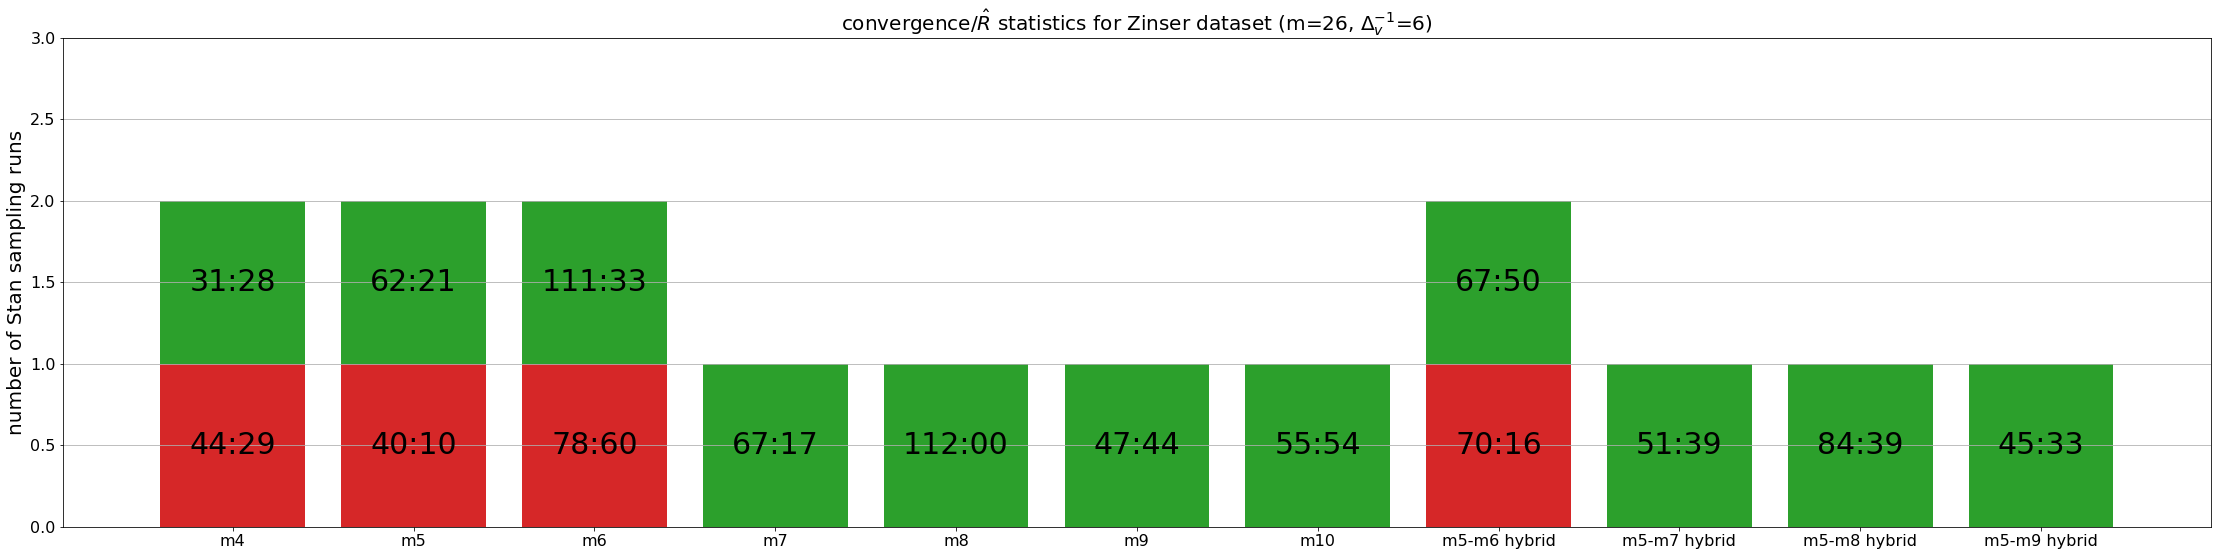

In [14]:
ylim_top = 0
for dataname in data:
    for model in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[model][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*3.5),len(data)*9), sharex=True, sharey=True, squeeze=False)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[model][dataname])
        height_good = len(maxrhats[model][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        
        if len(sampling_time[model][dataname]) != height_bad+height_good:
            print('{}, {}: Timing information inconsistent.'.format(dataname, desc_model[model]))
        else:
            for it, t in enumerate(sampling_time[model][dataname]):
                ax.text(x, it+0.5, '{:.0f}:{:02.0f}'.format(t//60, t%60), ha='center', va='center', size=30)
            
        xticks.append(x)
        xticklabels.append(desc_model[model].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

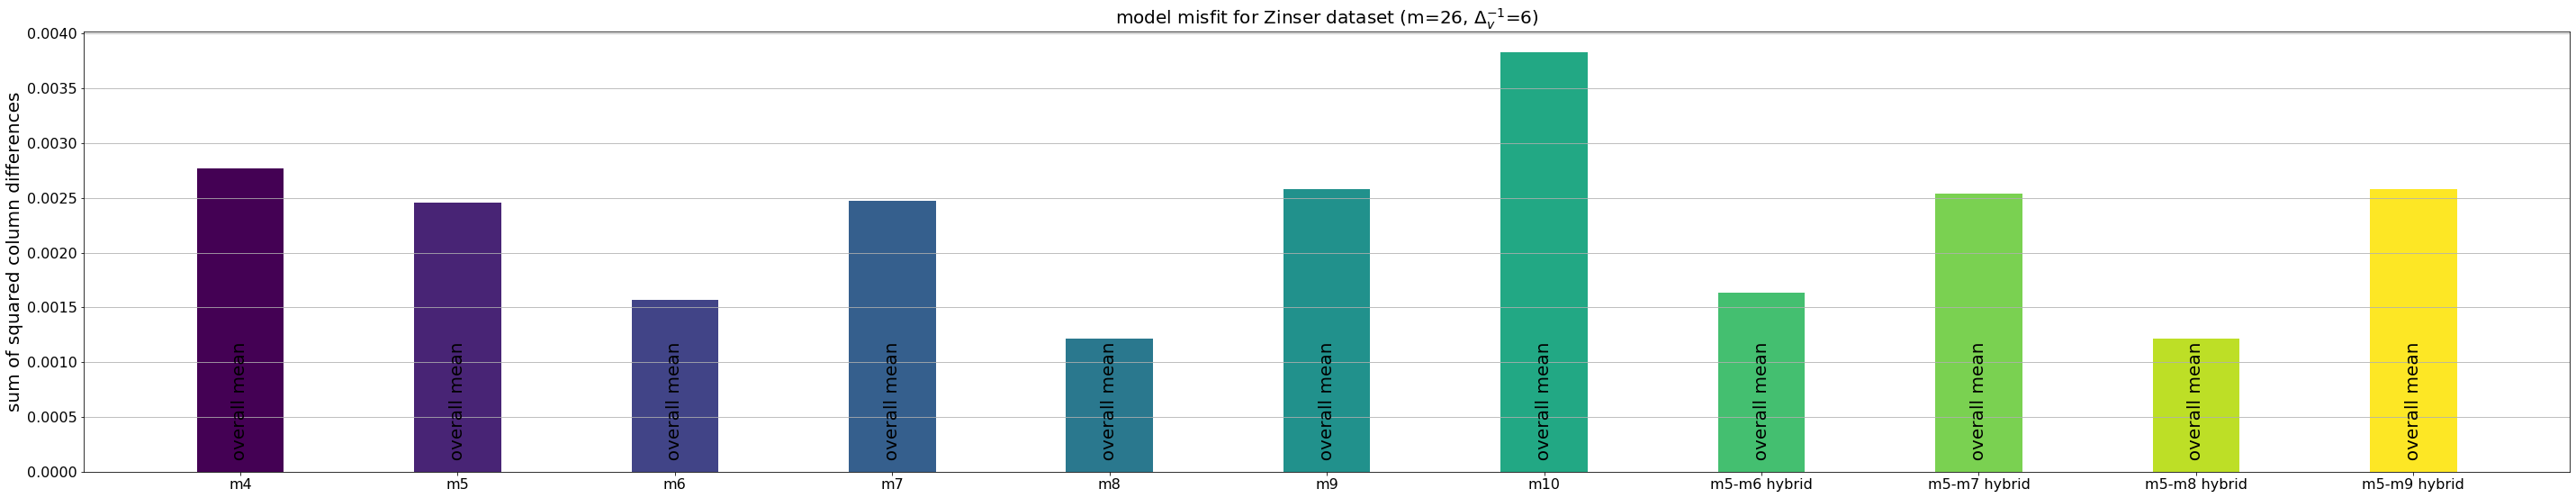

In [15]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[model],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[model])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[model].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

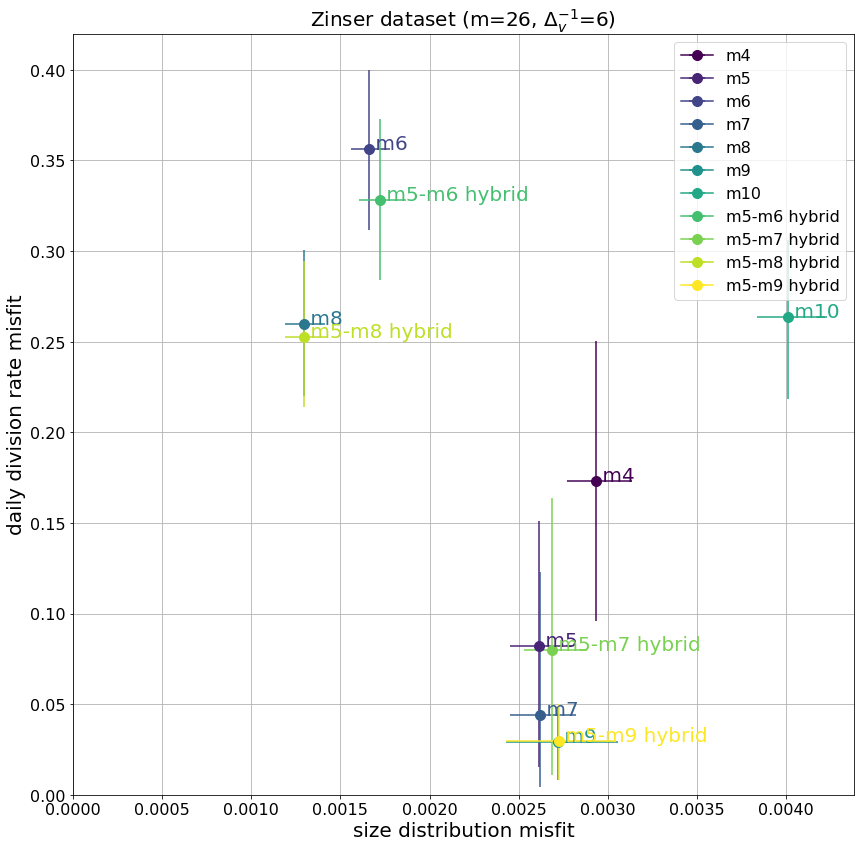

In [26]:
add_labels = True
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            
            if add_labels:
                ax.text(q0[2], q1[2], ' '+desc_model[model], color=eb[0].get_color(), size=20)
            
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

In [27]:
datanames = tuple(data.keys())
if len(datanames) > 1:
    fig, ax = plt.subplots(figsize=(14,14))

    for model in mcmcs:
        qq = {}
        # misfit to data
        for dataname in datanames:
            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2

            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

            qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))

        q0 = qq[datanames[0]]
        q1 = qq[datanames[1]]

        eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
        ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
        if maxrhats_final[model][dataname] > 1.1:
            ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)

    ax.grid(True)
    ax.legend()
    ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
           ylabel='{} size distribution misfit'.format(desc[datanames[1]]))
    ax.set_xlim(left=0.0)
    ax.set_ylim(bottom=0.0)
None

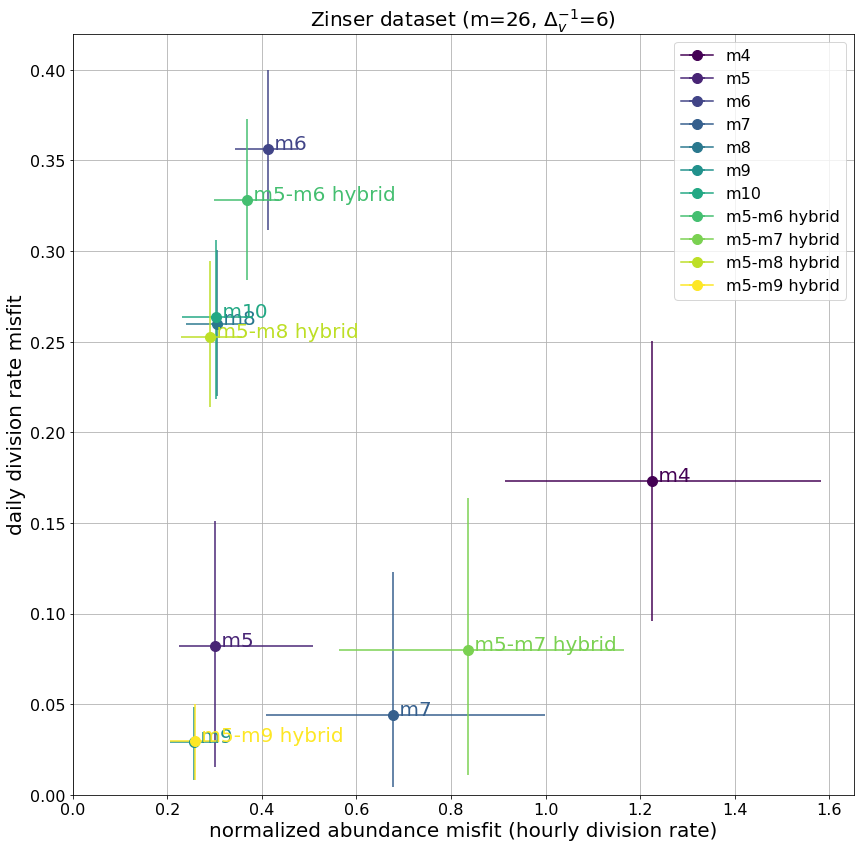

In [28]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')
t_zinser = data_fig2a['exper time'] * 60
ab_mean_norm = 0.5*(data_fig2a['cells A'].values/data_fig2a['cells A'].values[0] + 
                    data_fig2a['cells B'].values/data_fig2a['cells B'].values[0])

add_labels = True
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # make sure the time is right, if not implement something fancier
            assert all(t_zinser.values[:-1] == data[dataname]['t_obs'])
            
            # misfit to normalized abundance
            
            e0 = np.mean(np.abs(np.sum(mcmcs[model][dataname]['mod_obspos'], axis=1)[:,1:]-ab_mean_norm[1:-1]), axis=1)
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            if add_labels:
                ax.text(q0[2], q1[2], ' '+desc_model[model], color=eb[0].get_color(), size=20)
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='normalized abundance misfit (hourly division rate)', ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

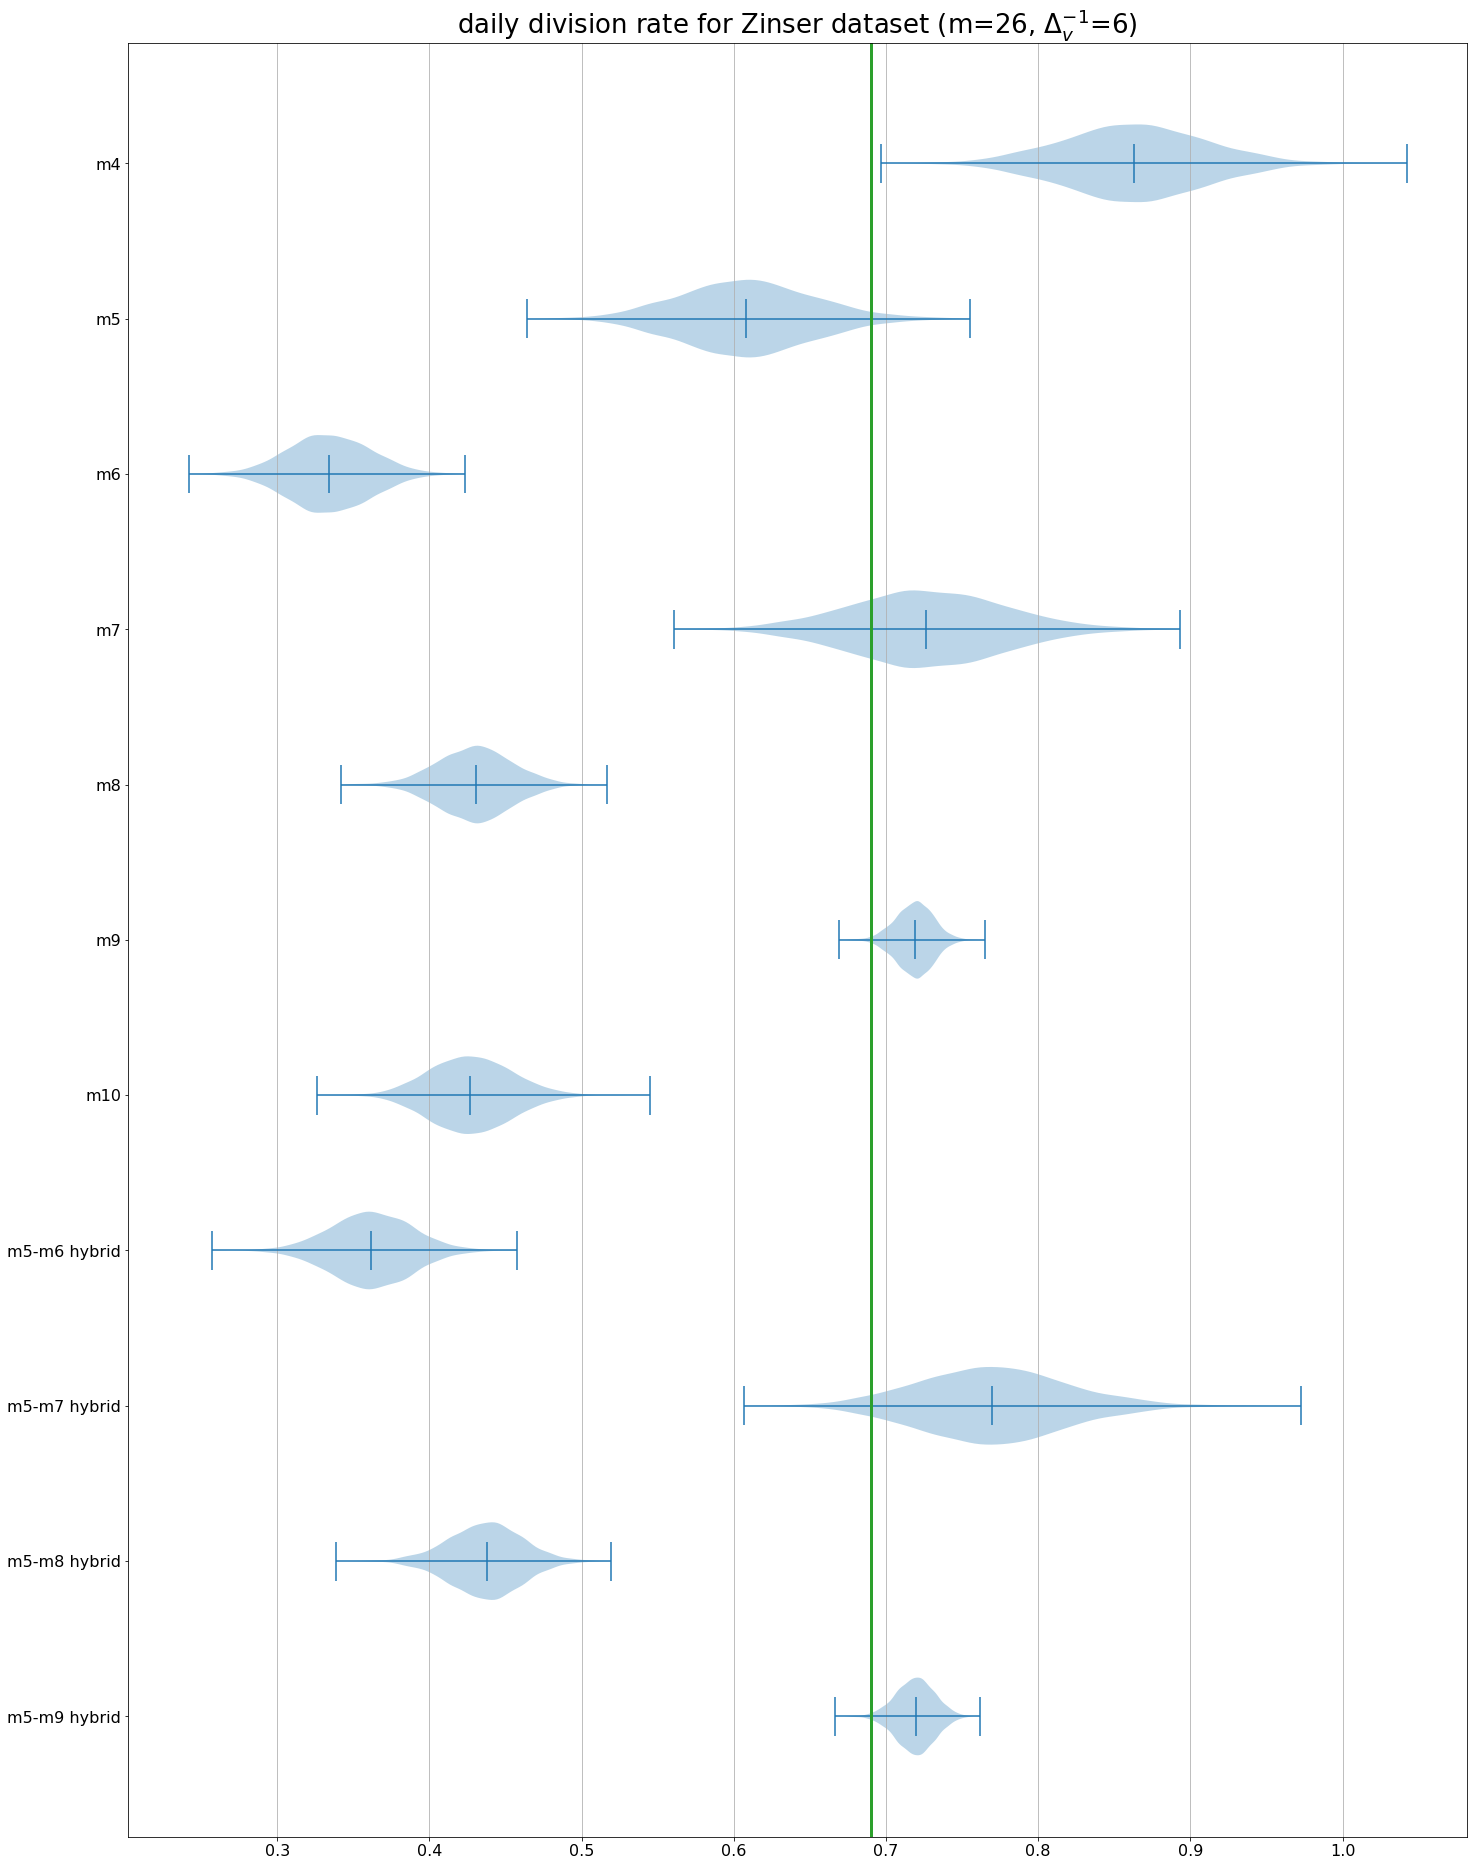

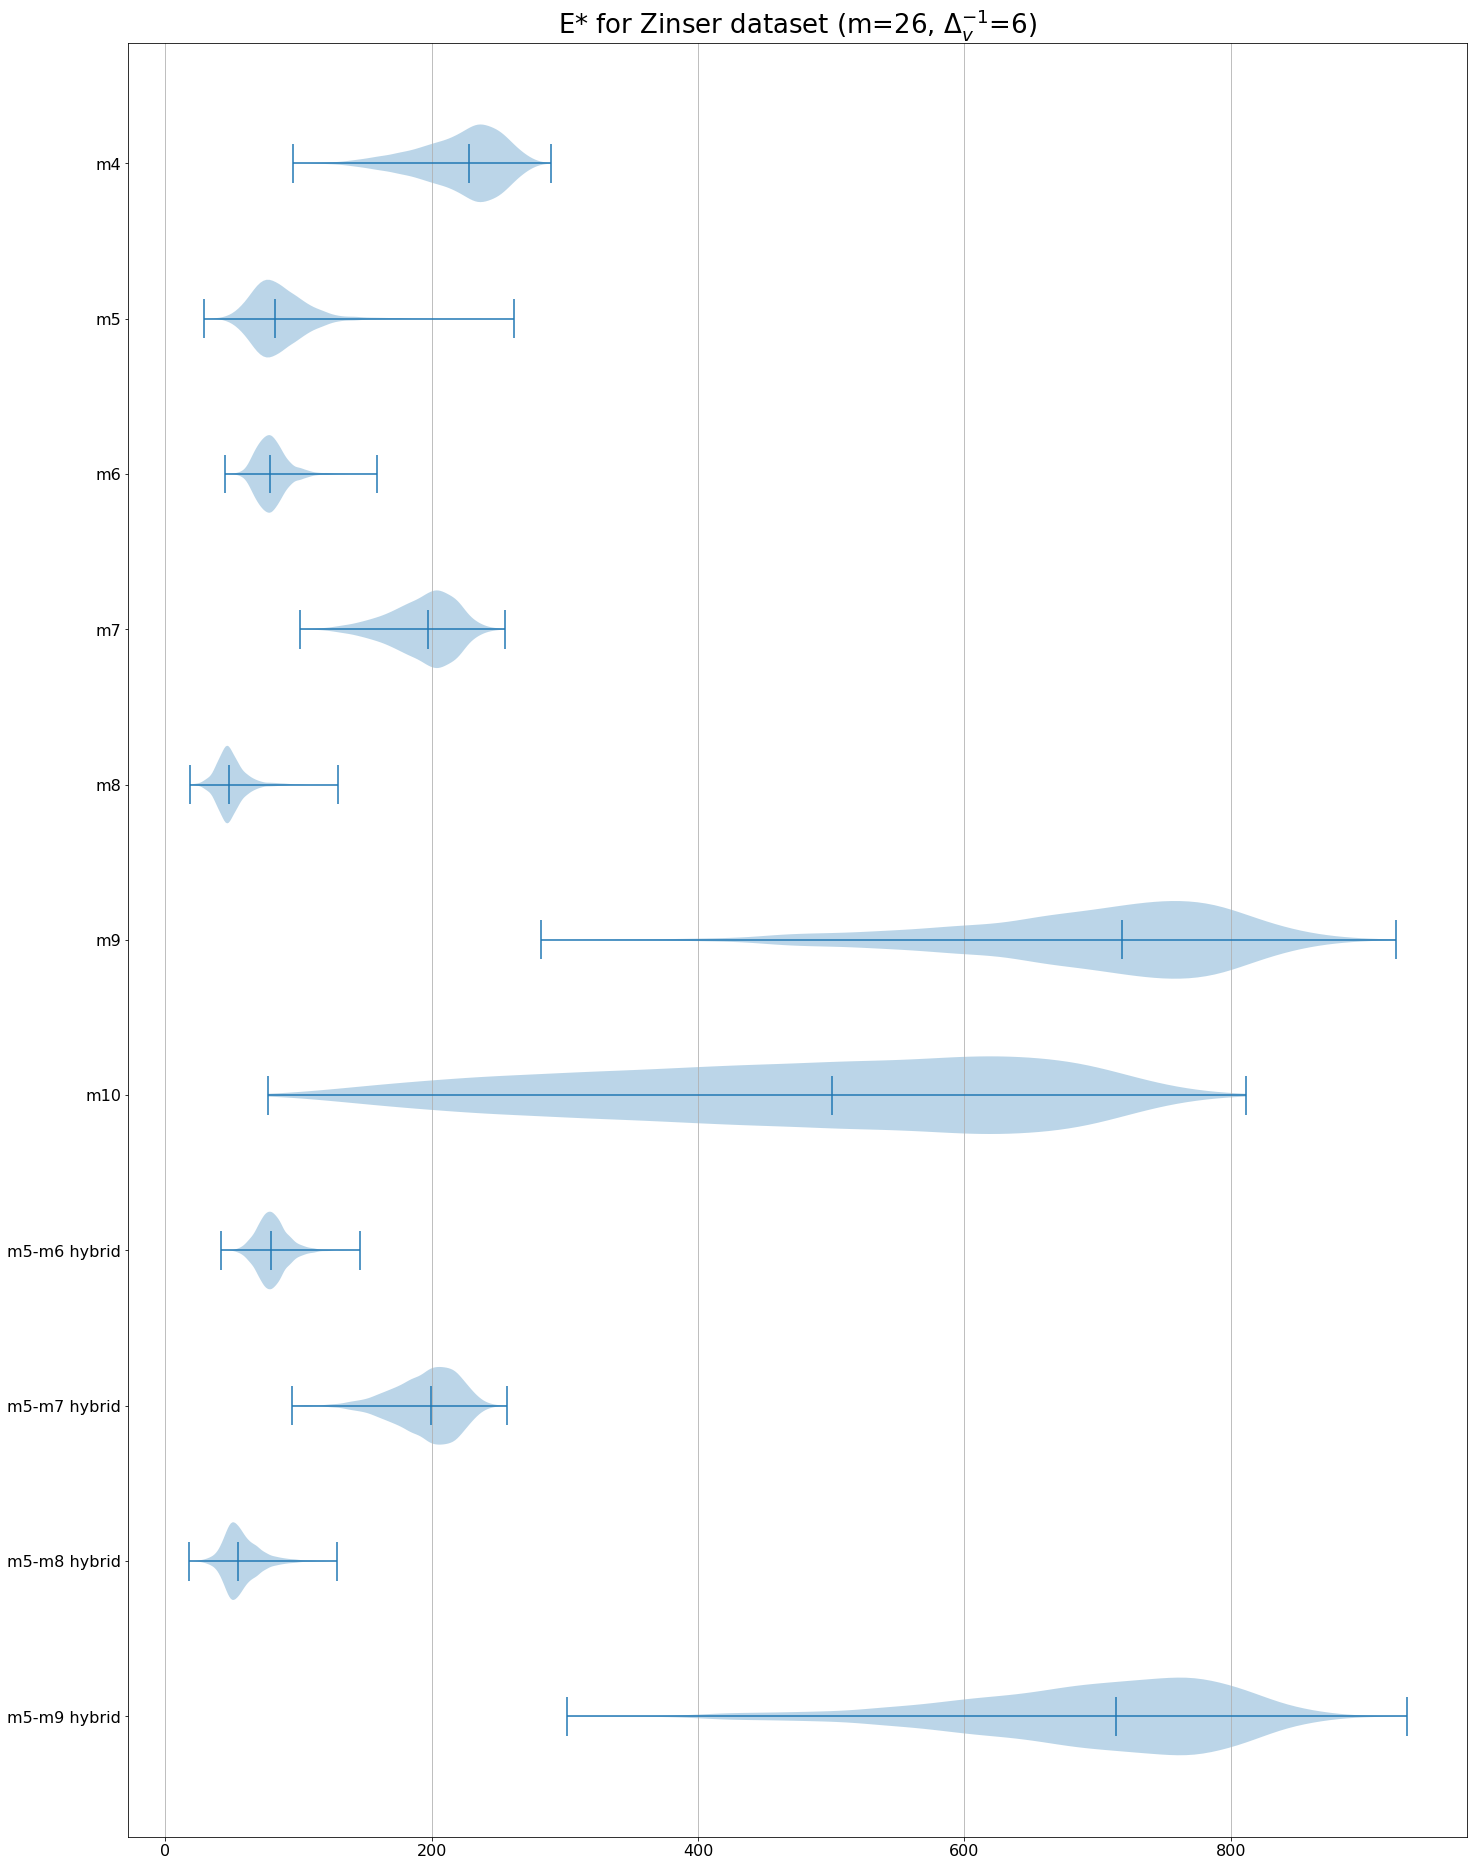

In [20]:
for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[model][dataname][param] for model in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[model].replace(',',',\n') for model in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,model in enumerate(mcmcs):
            if maxrhats_final[model][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

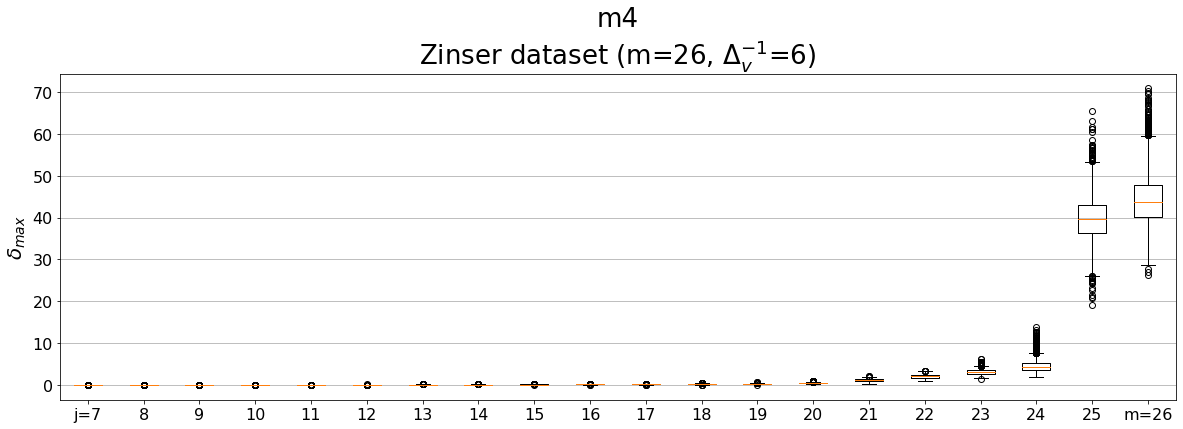

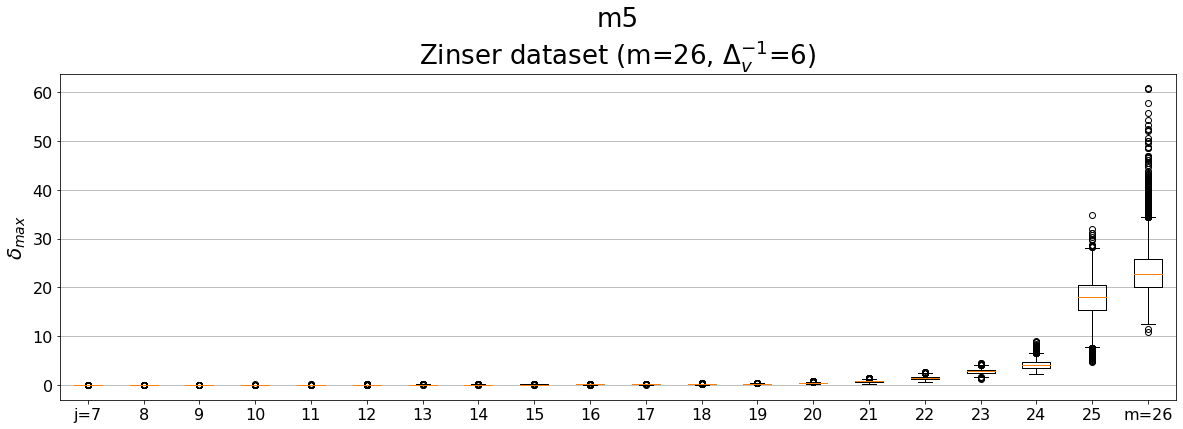

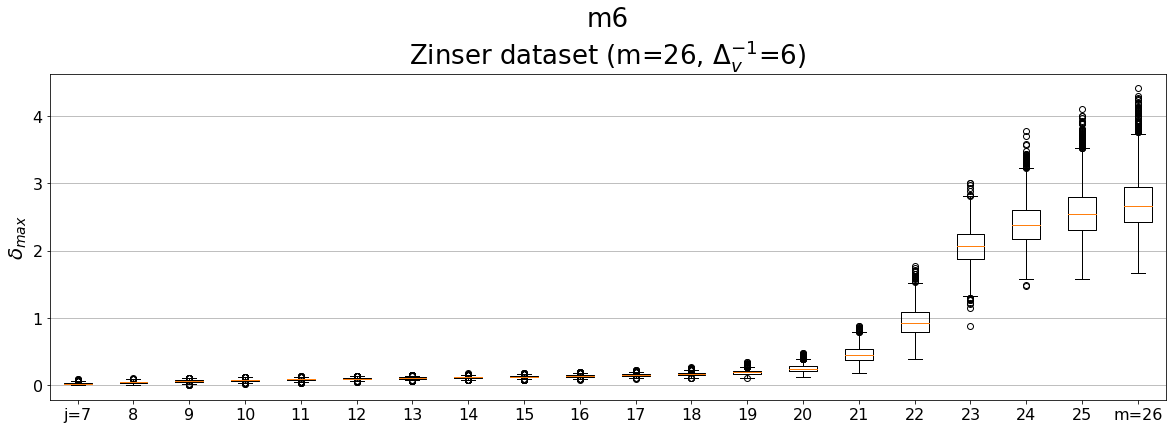

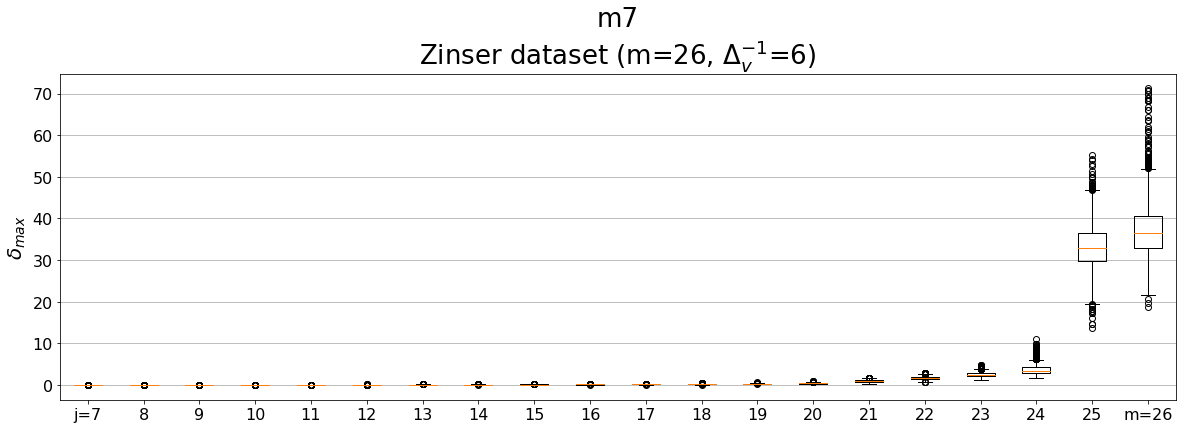

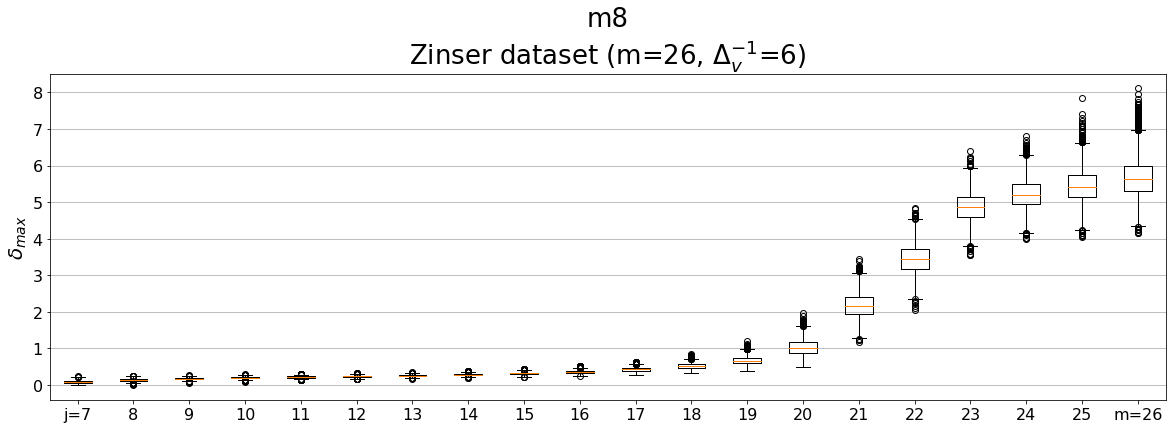

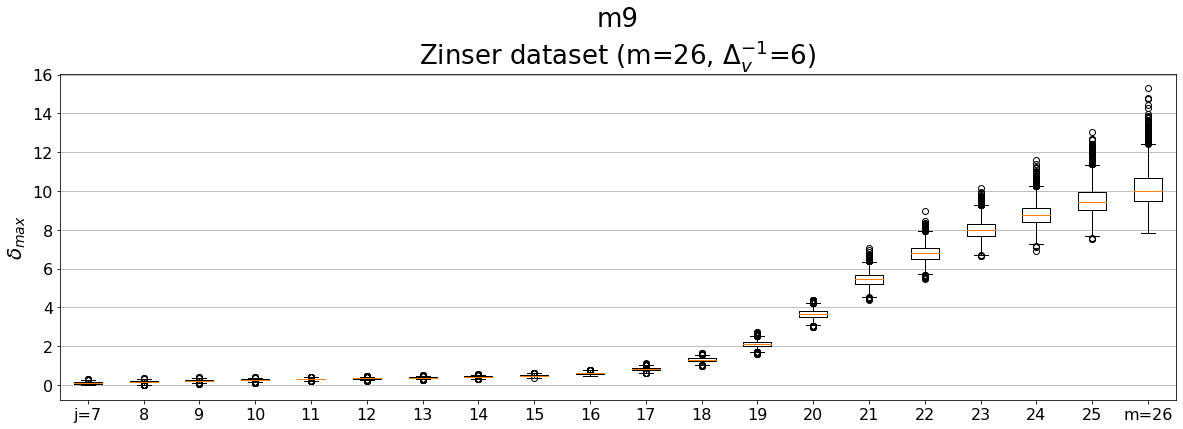

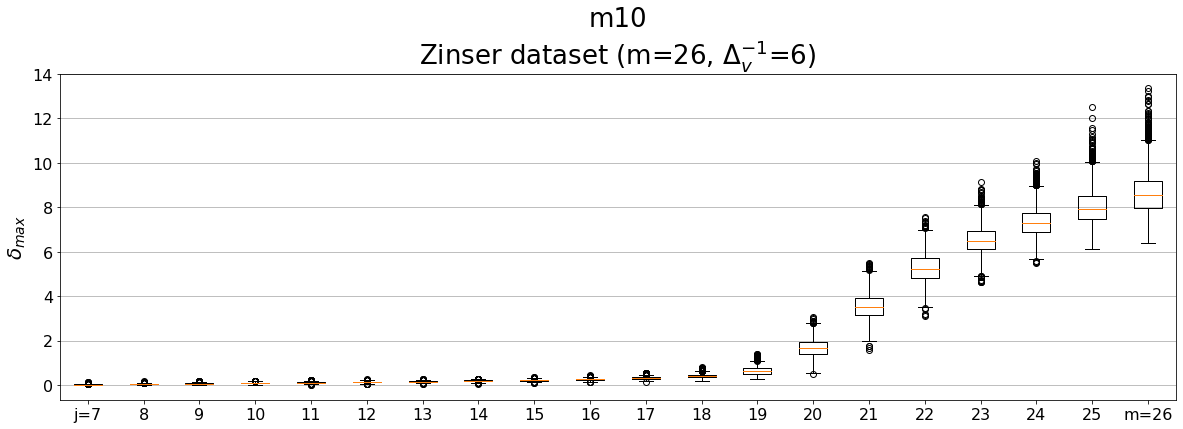

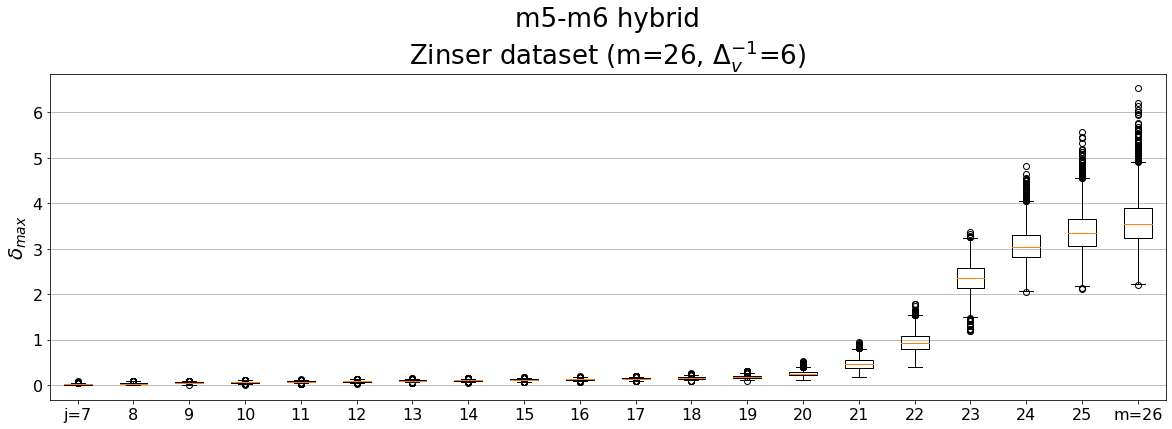

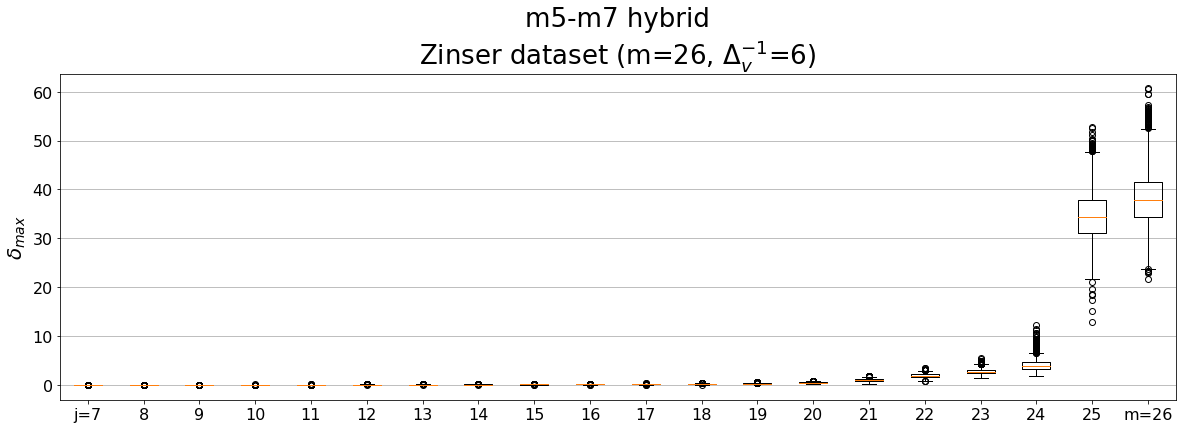

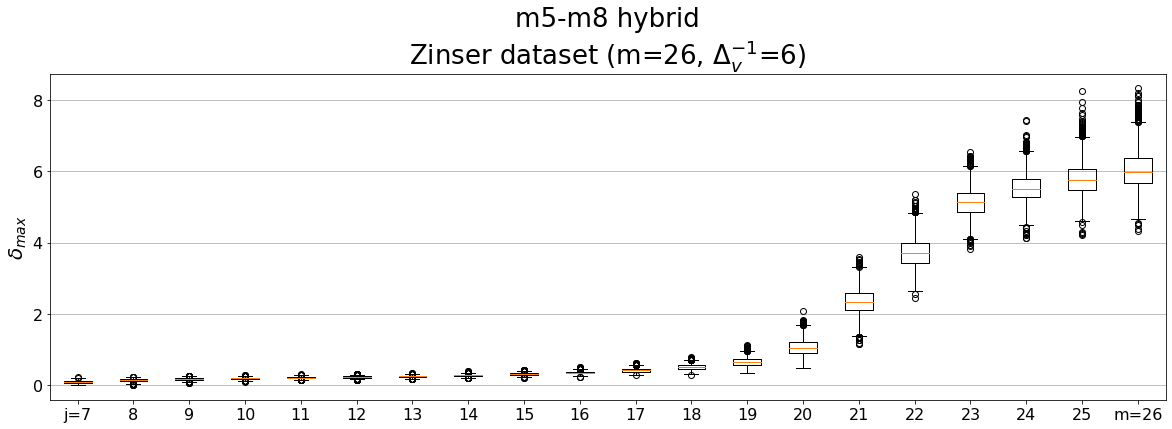

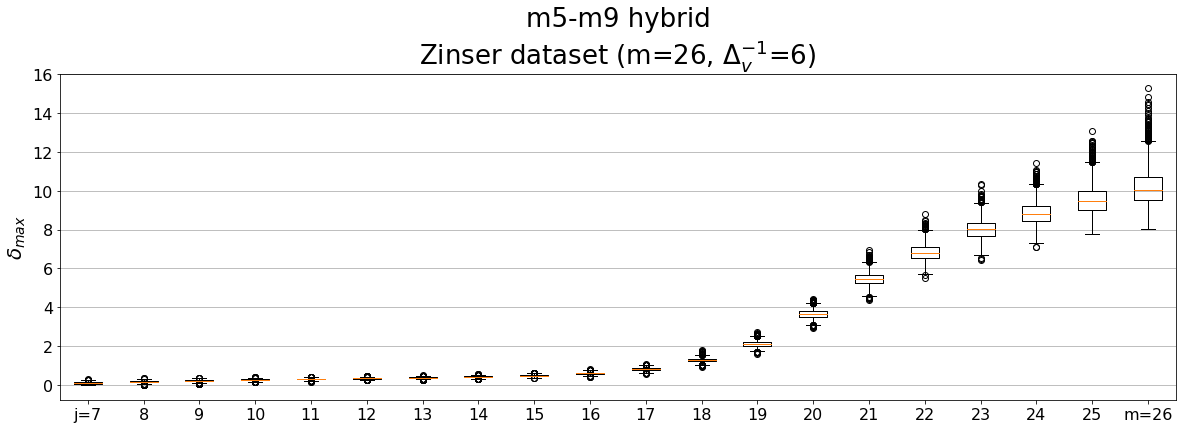

In [21]:
for dataname in data:
    for model,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[model] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

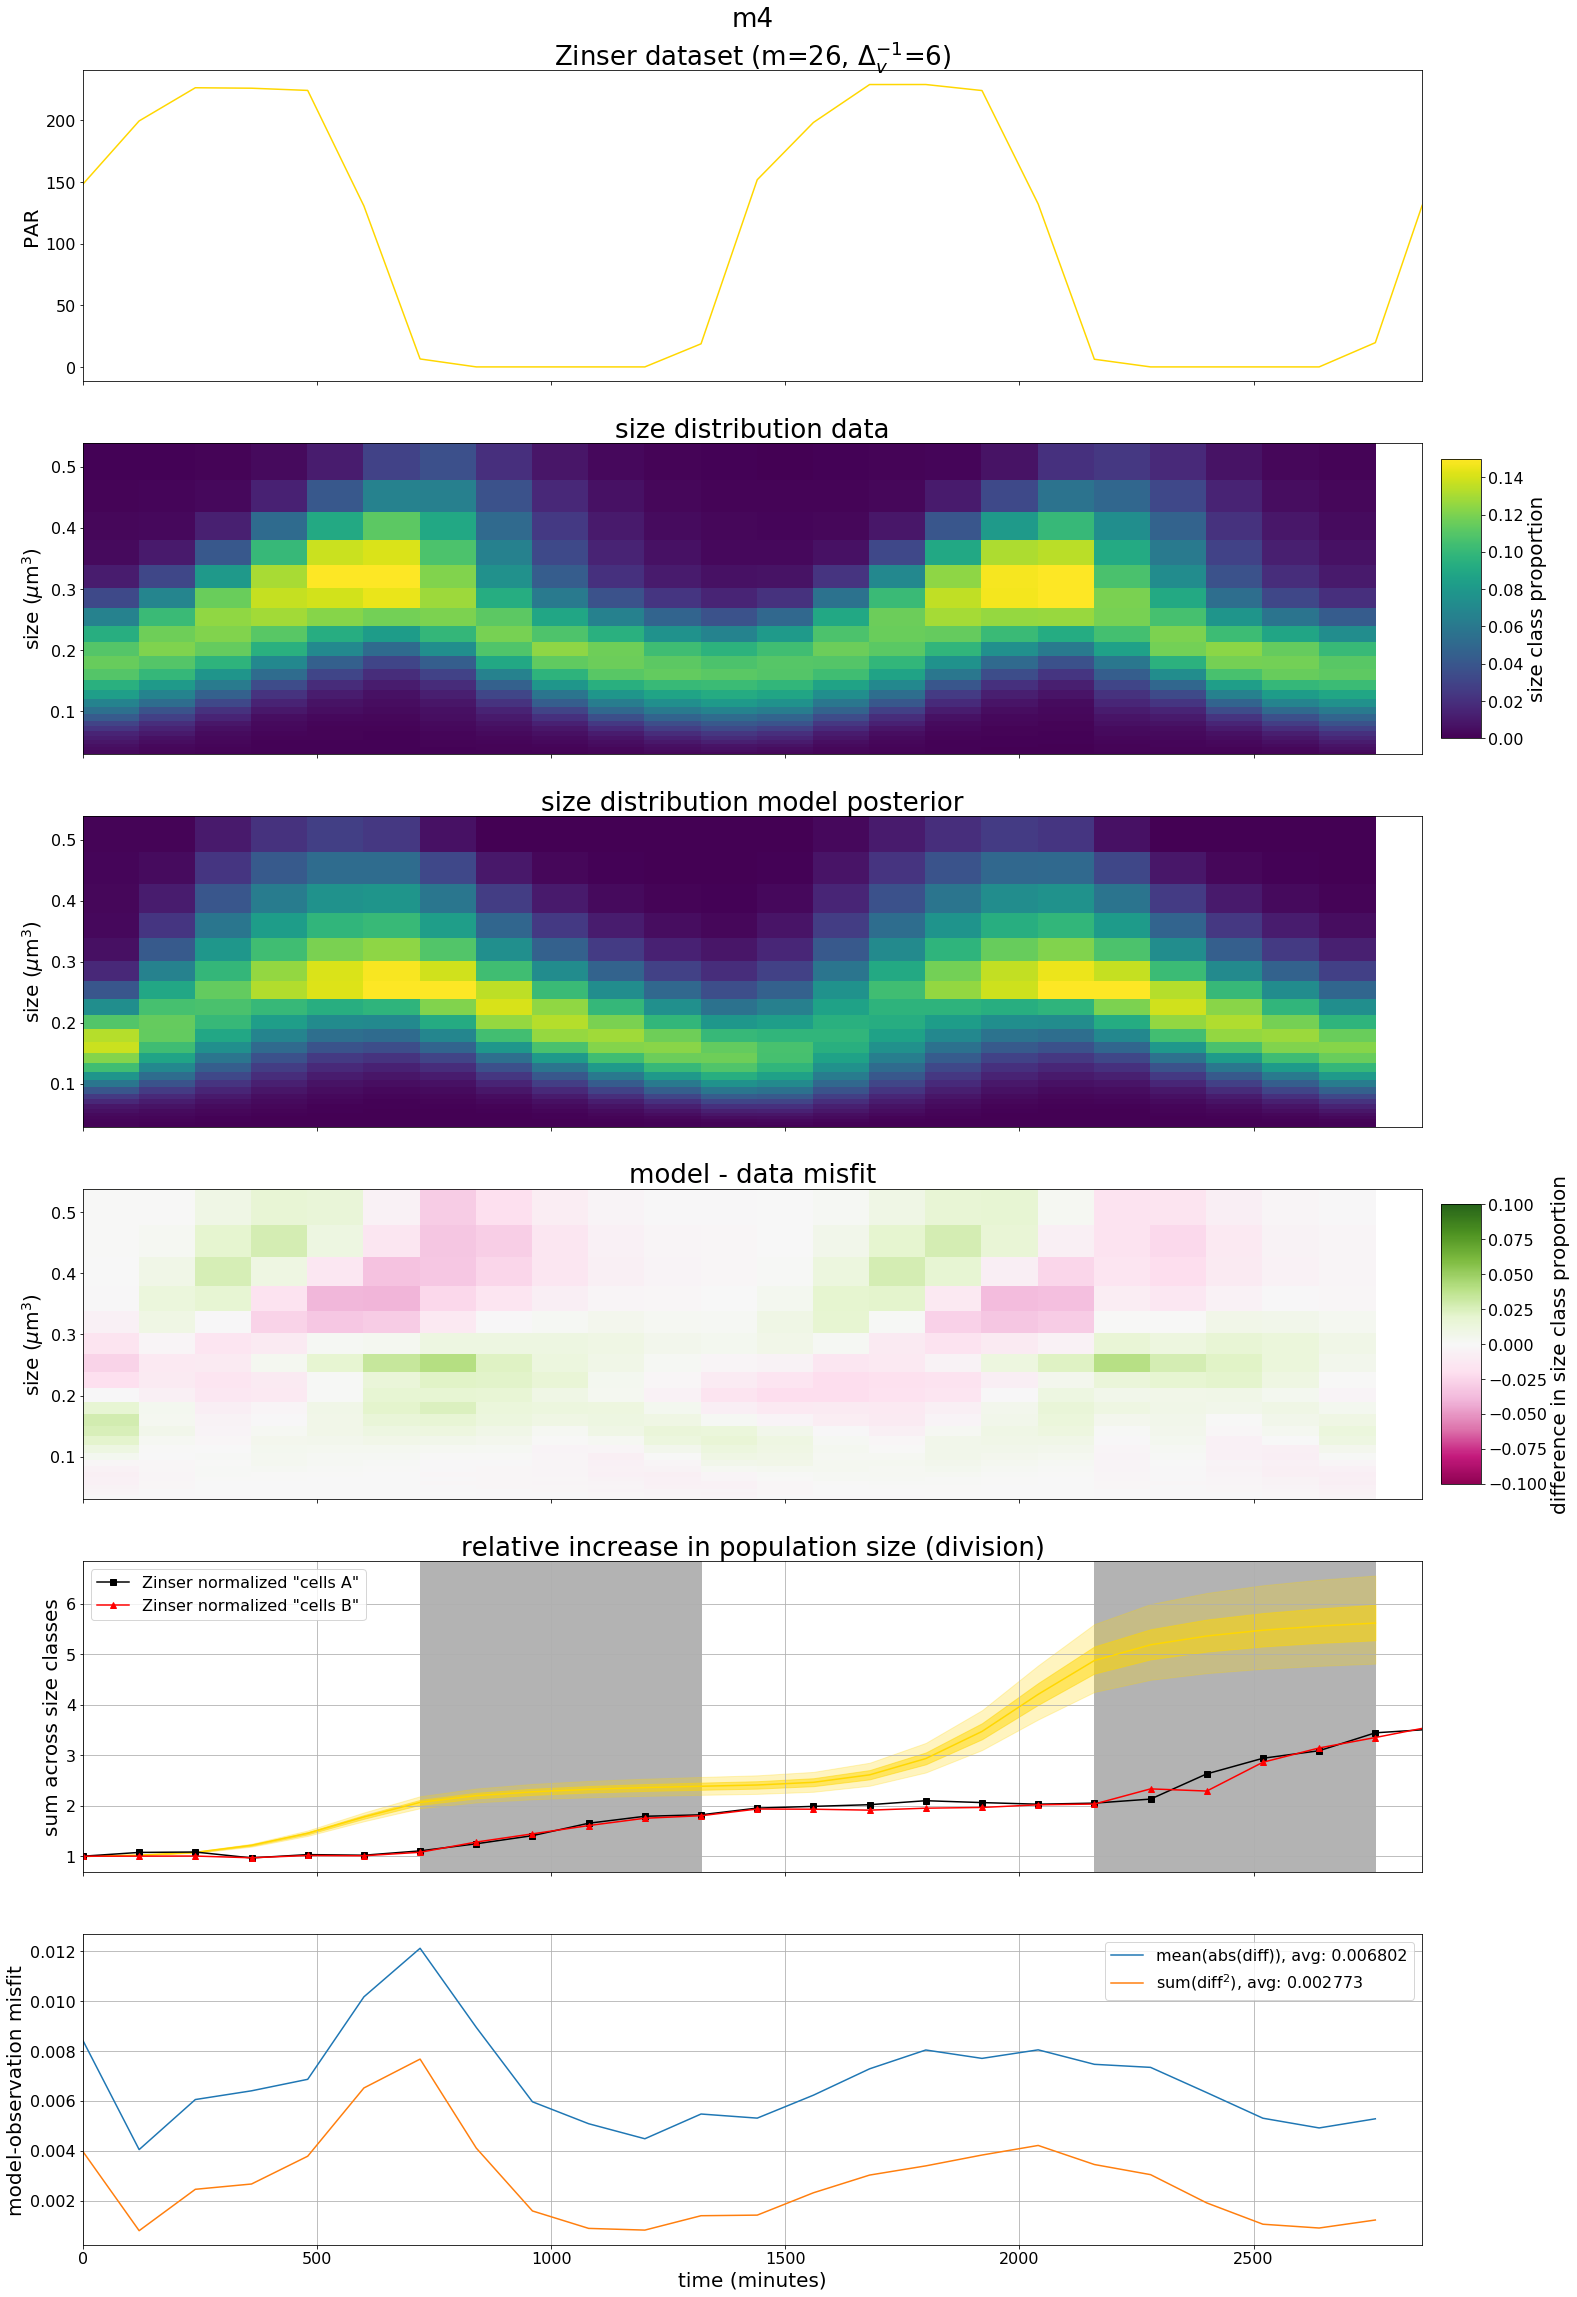

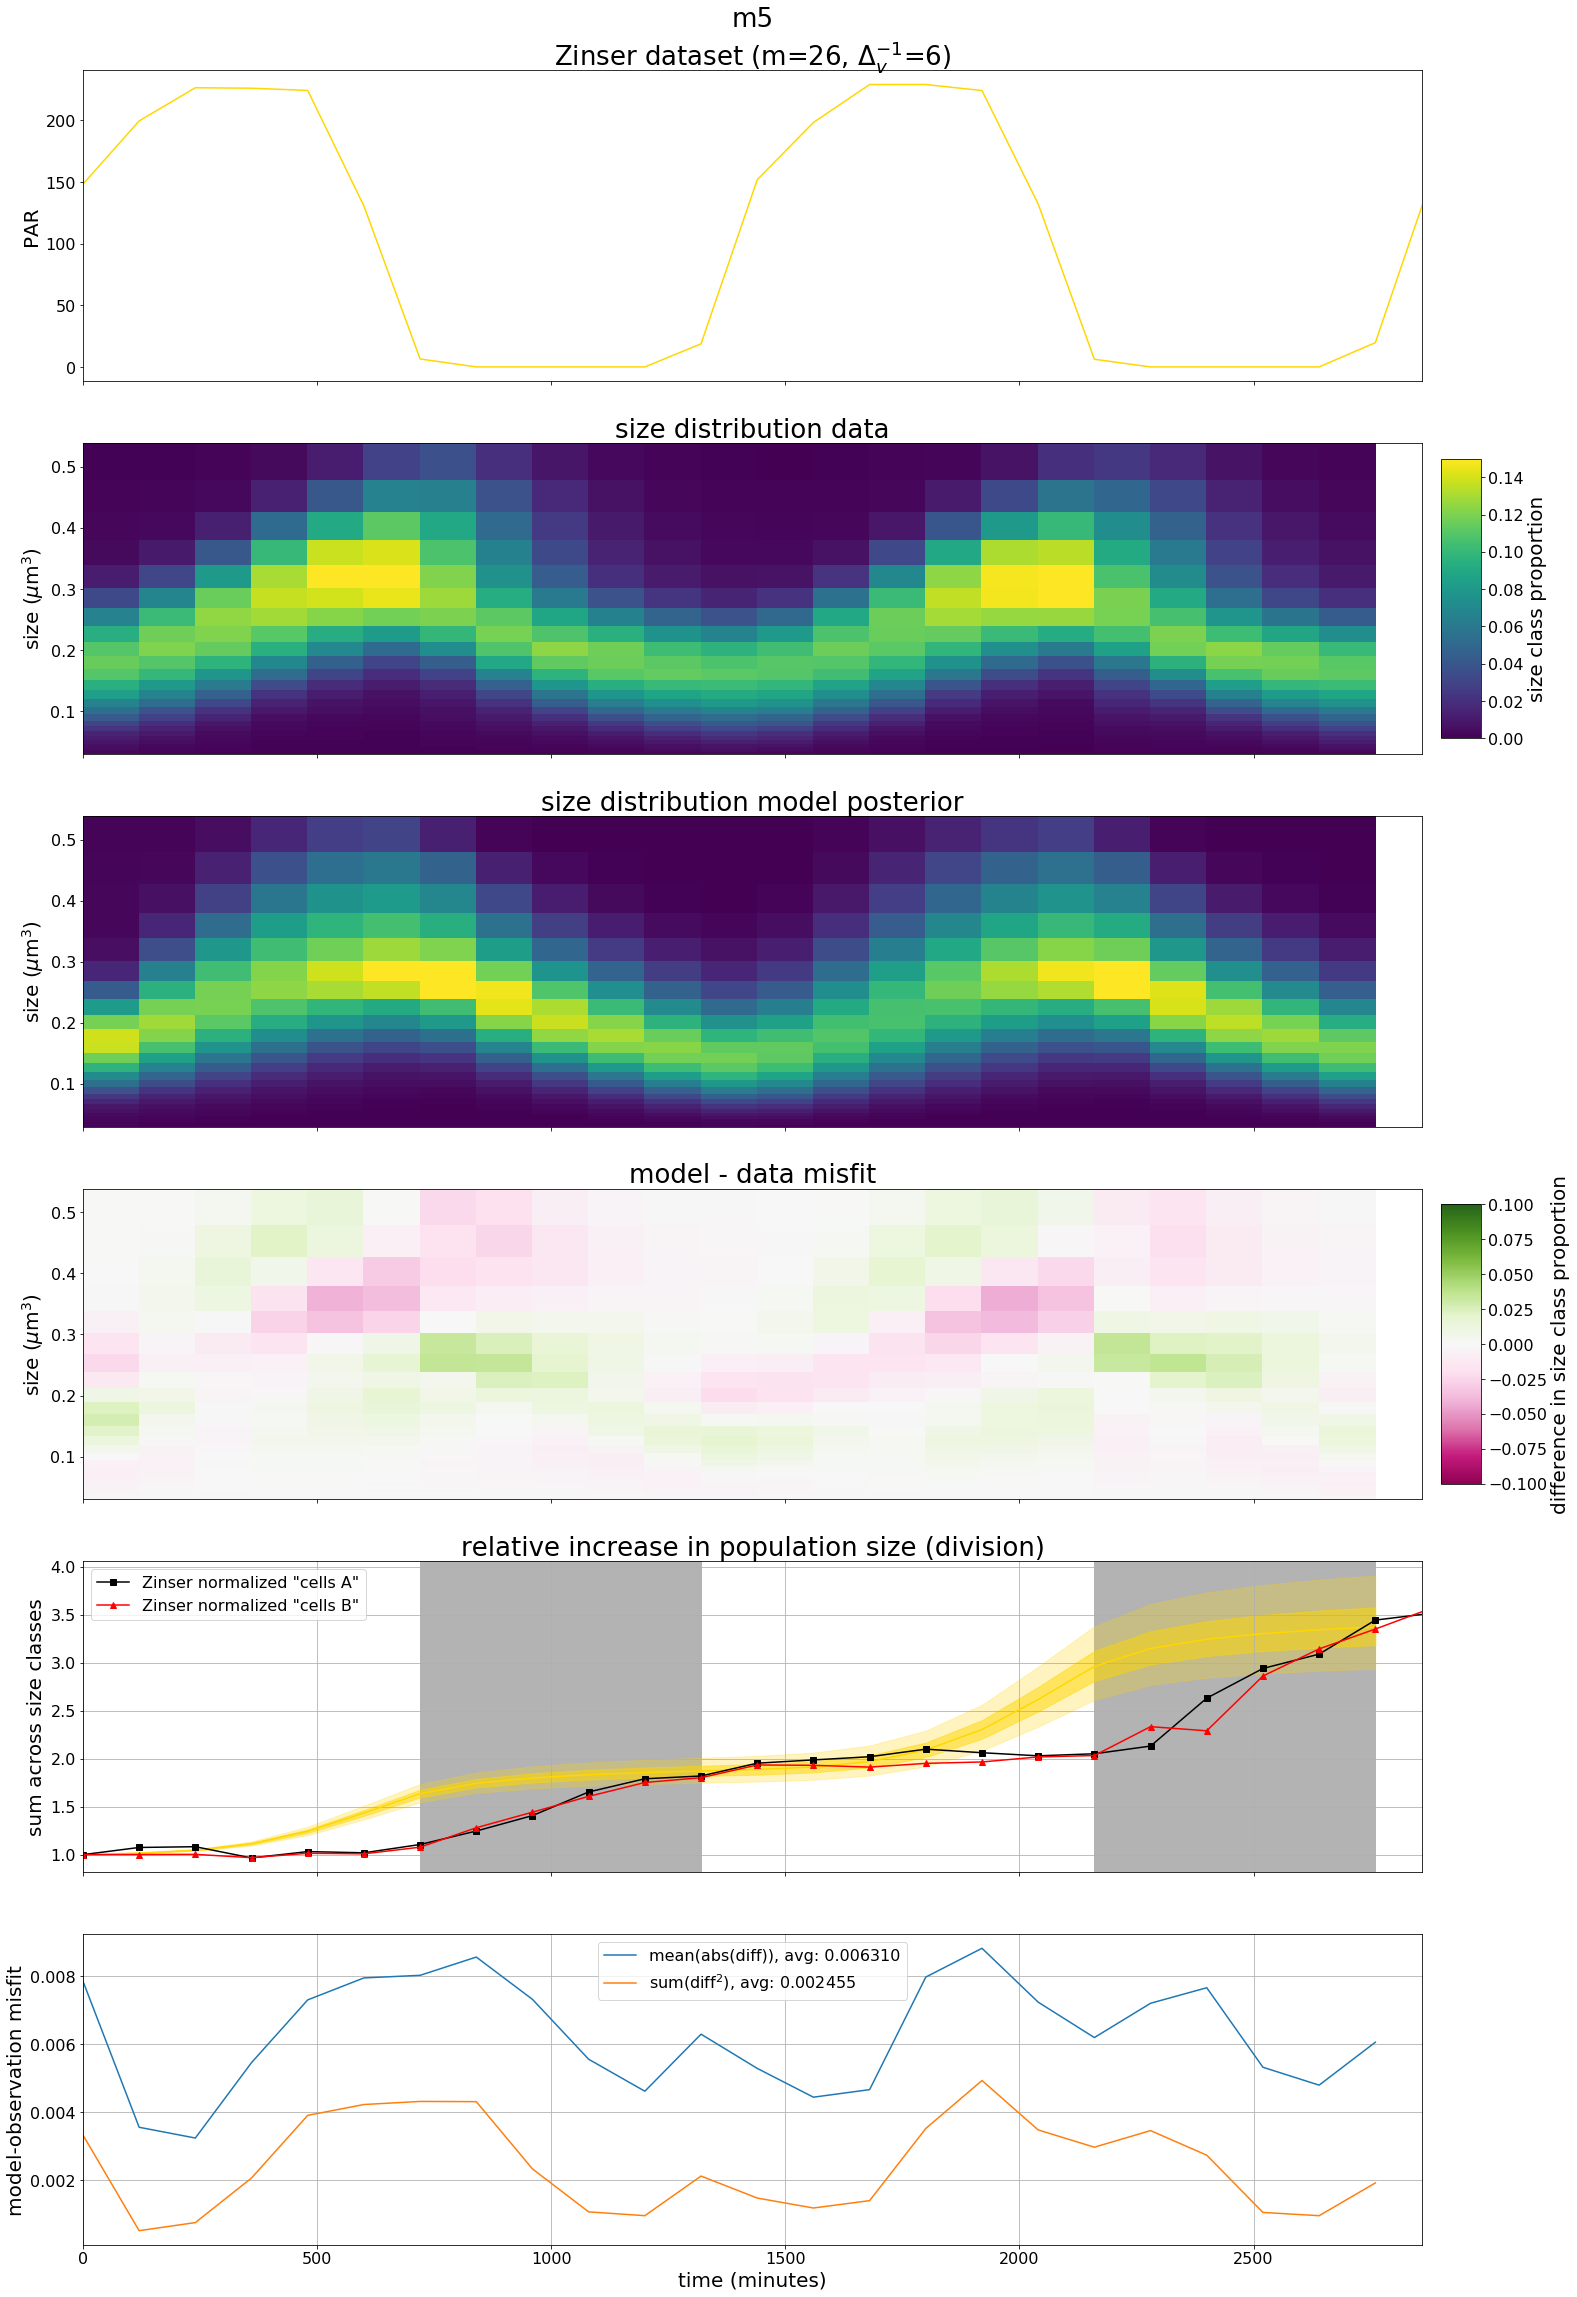

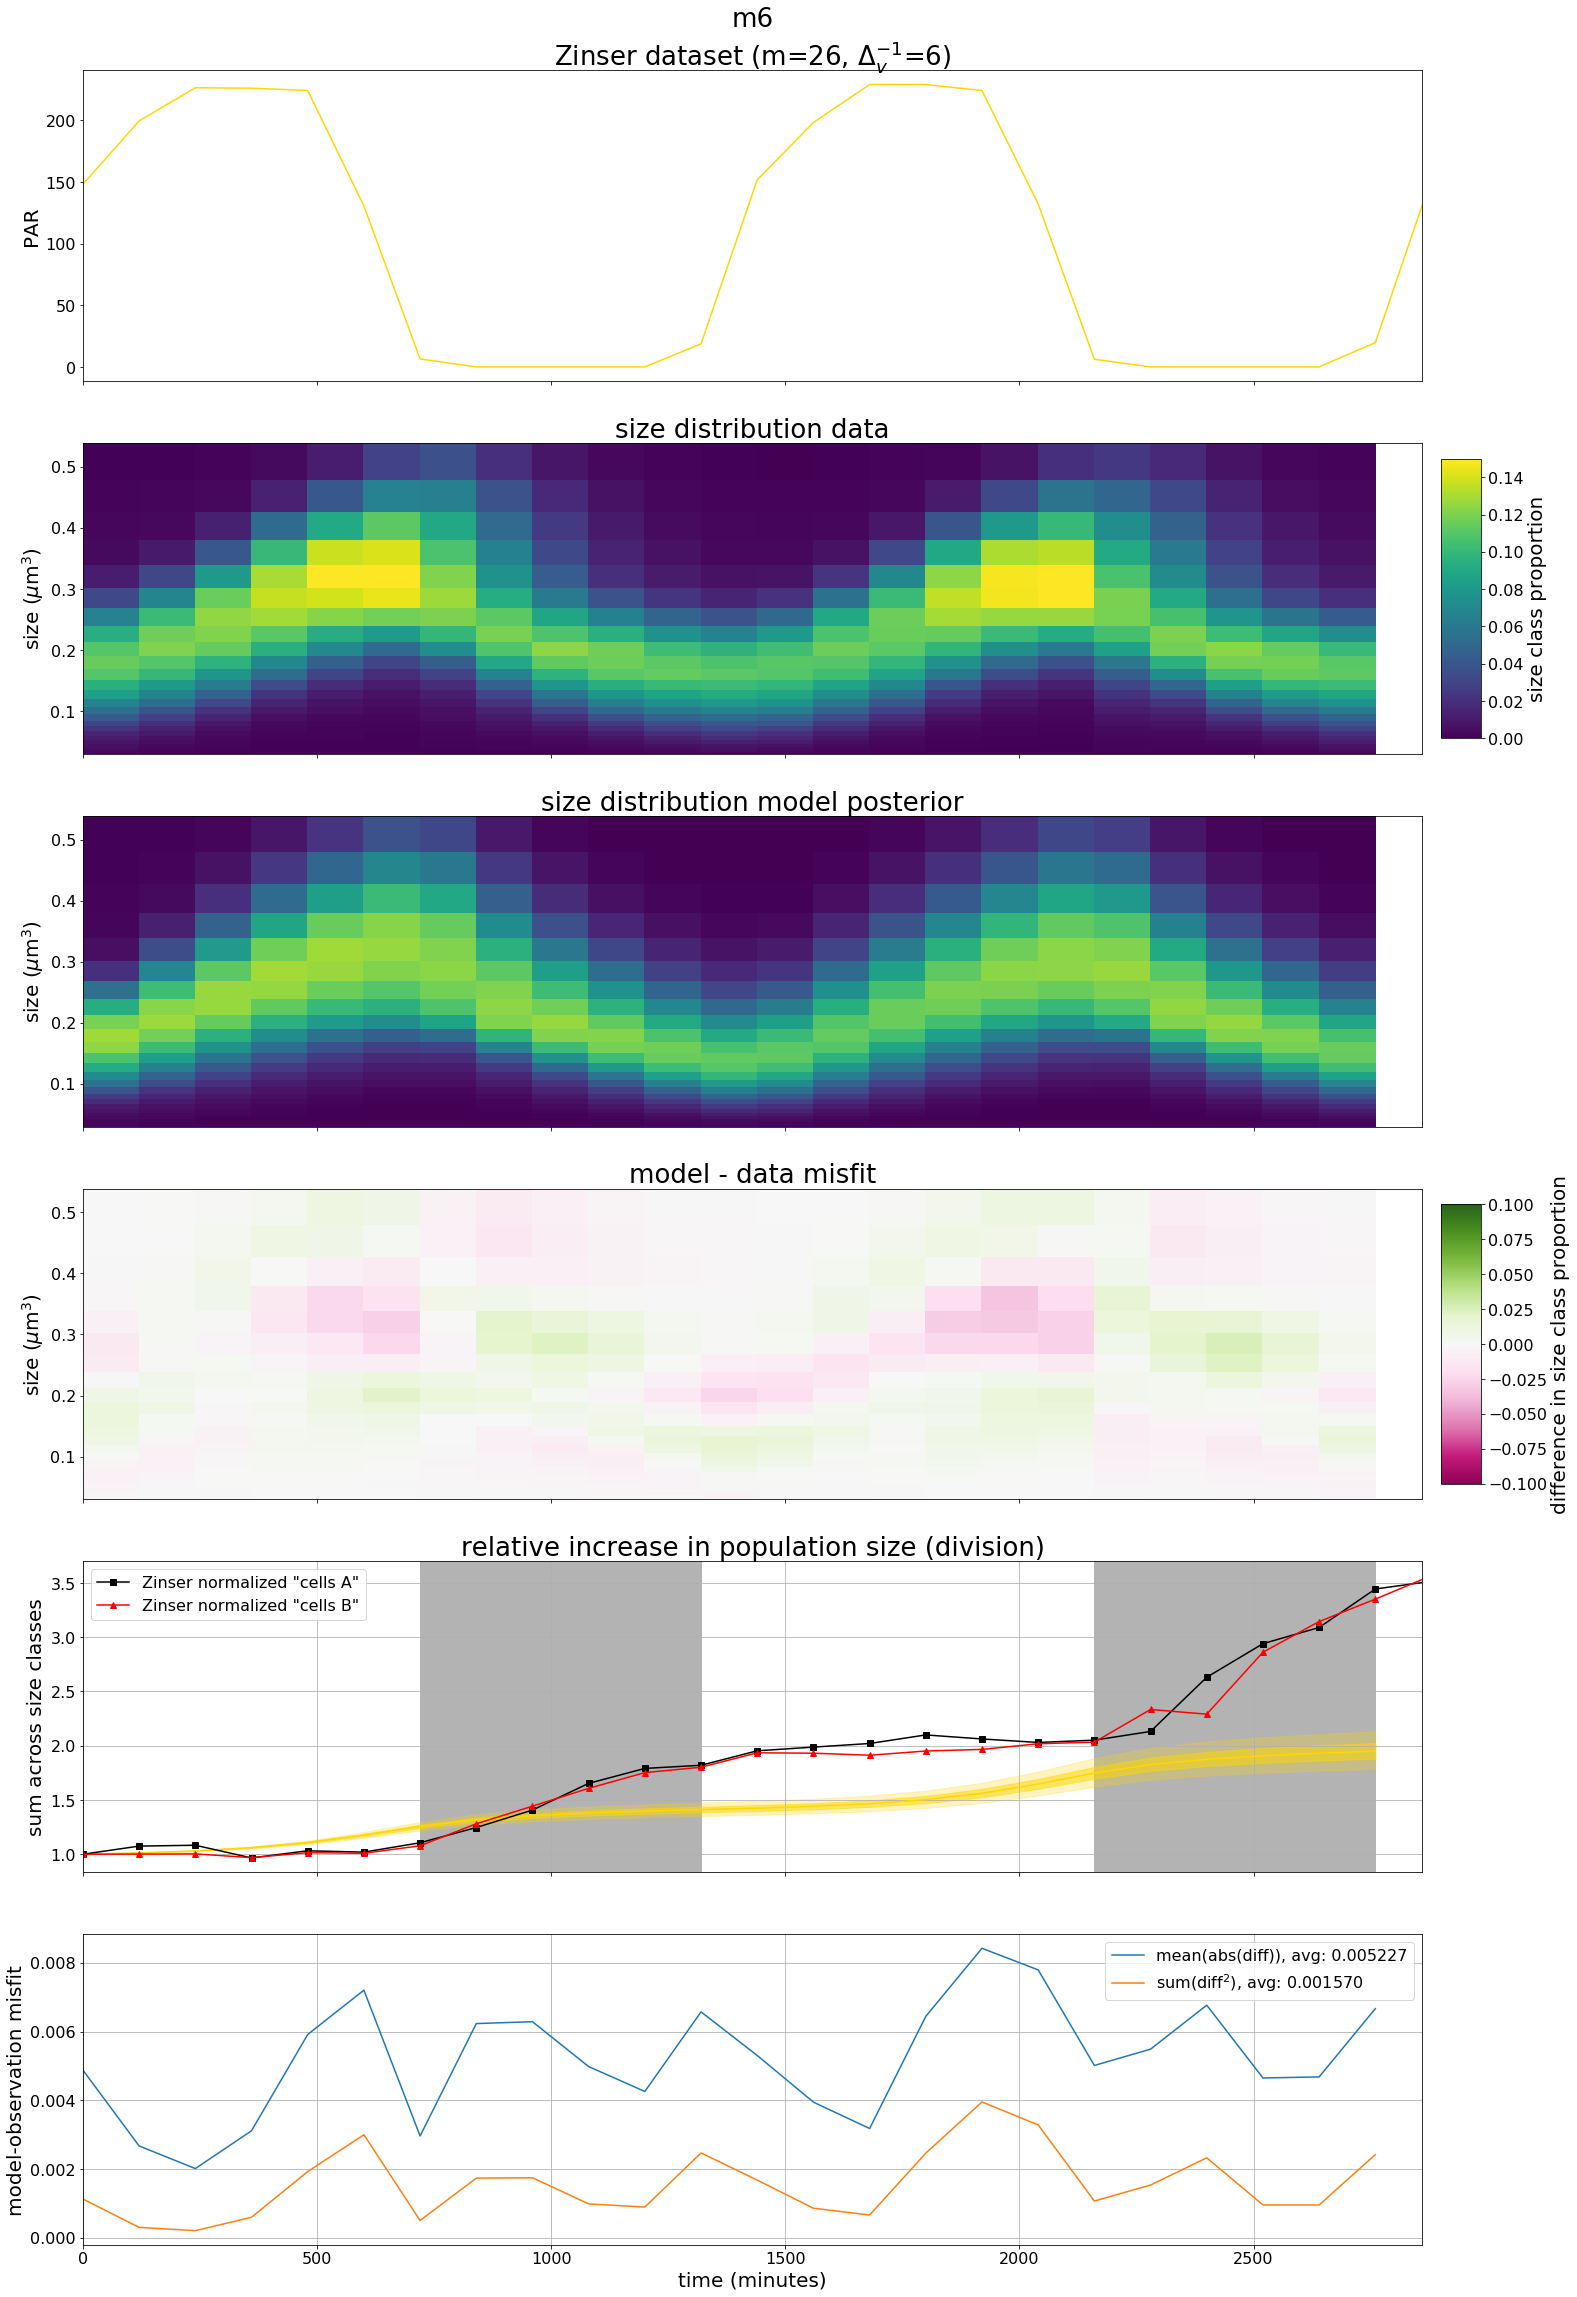

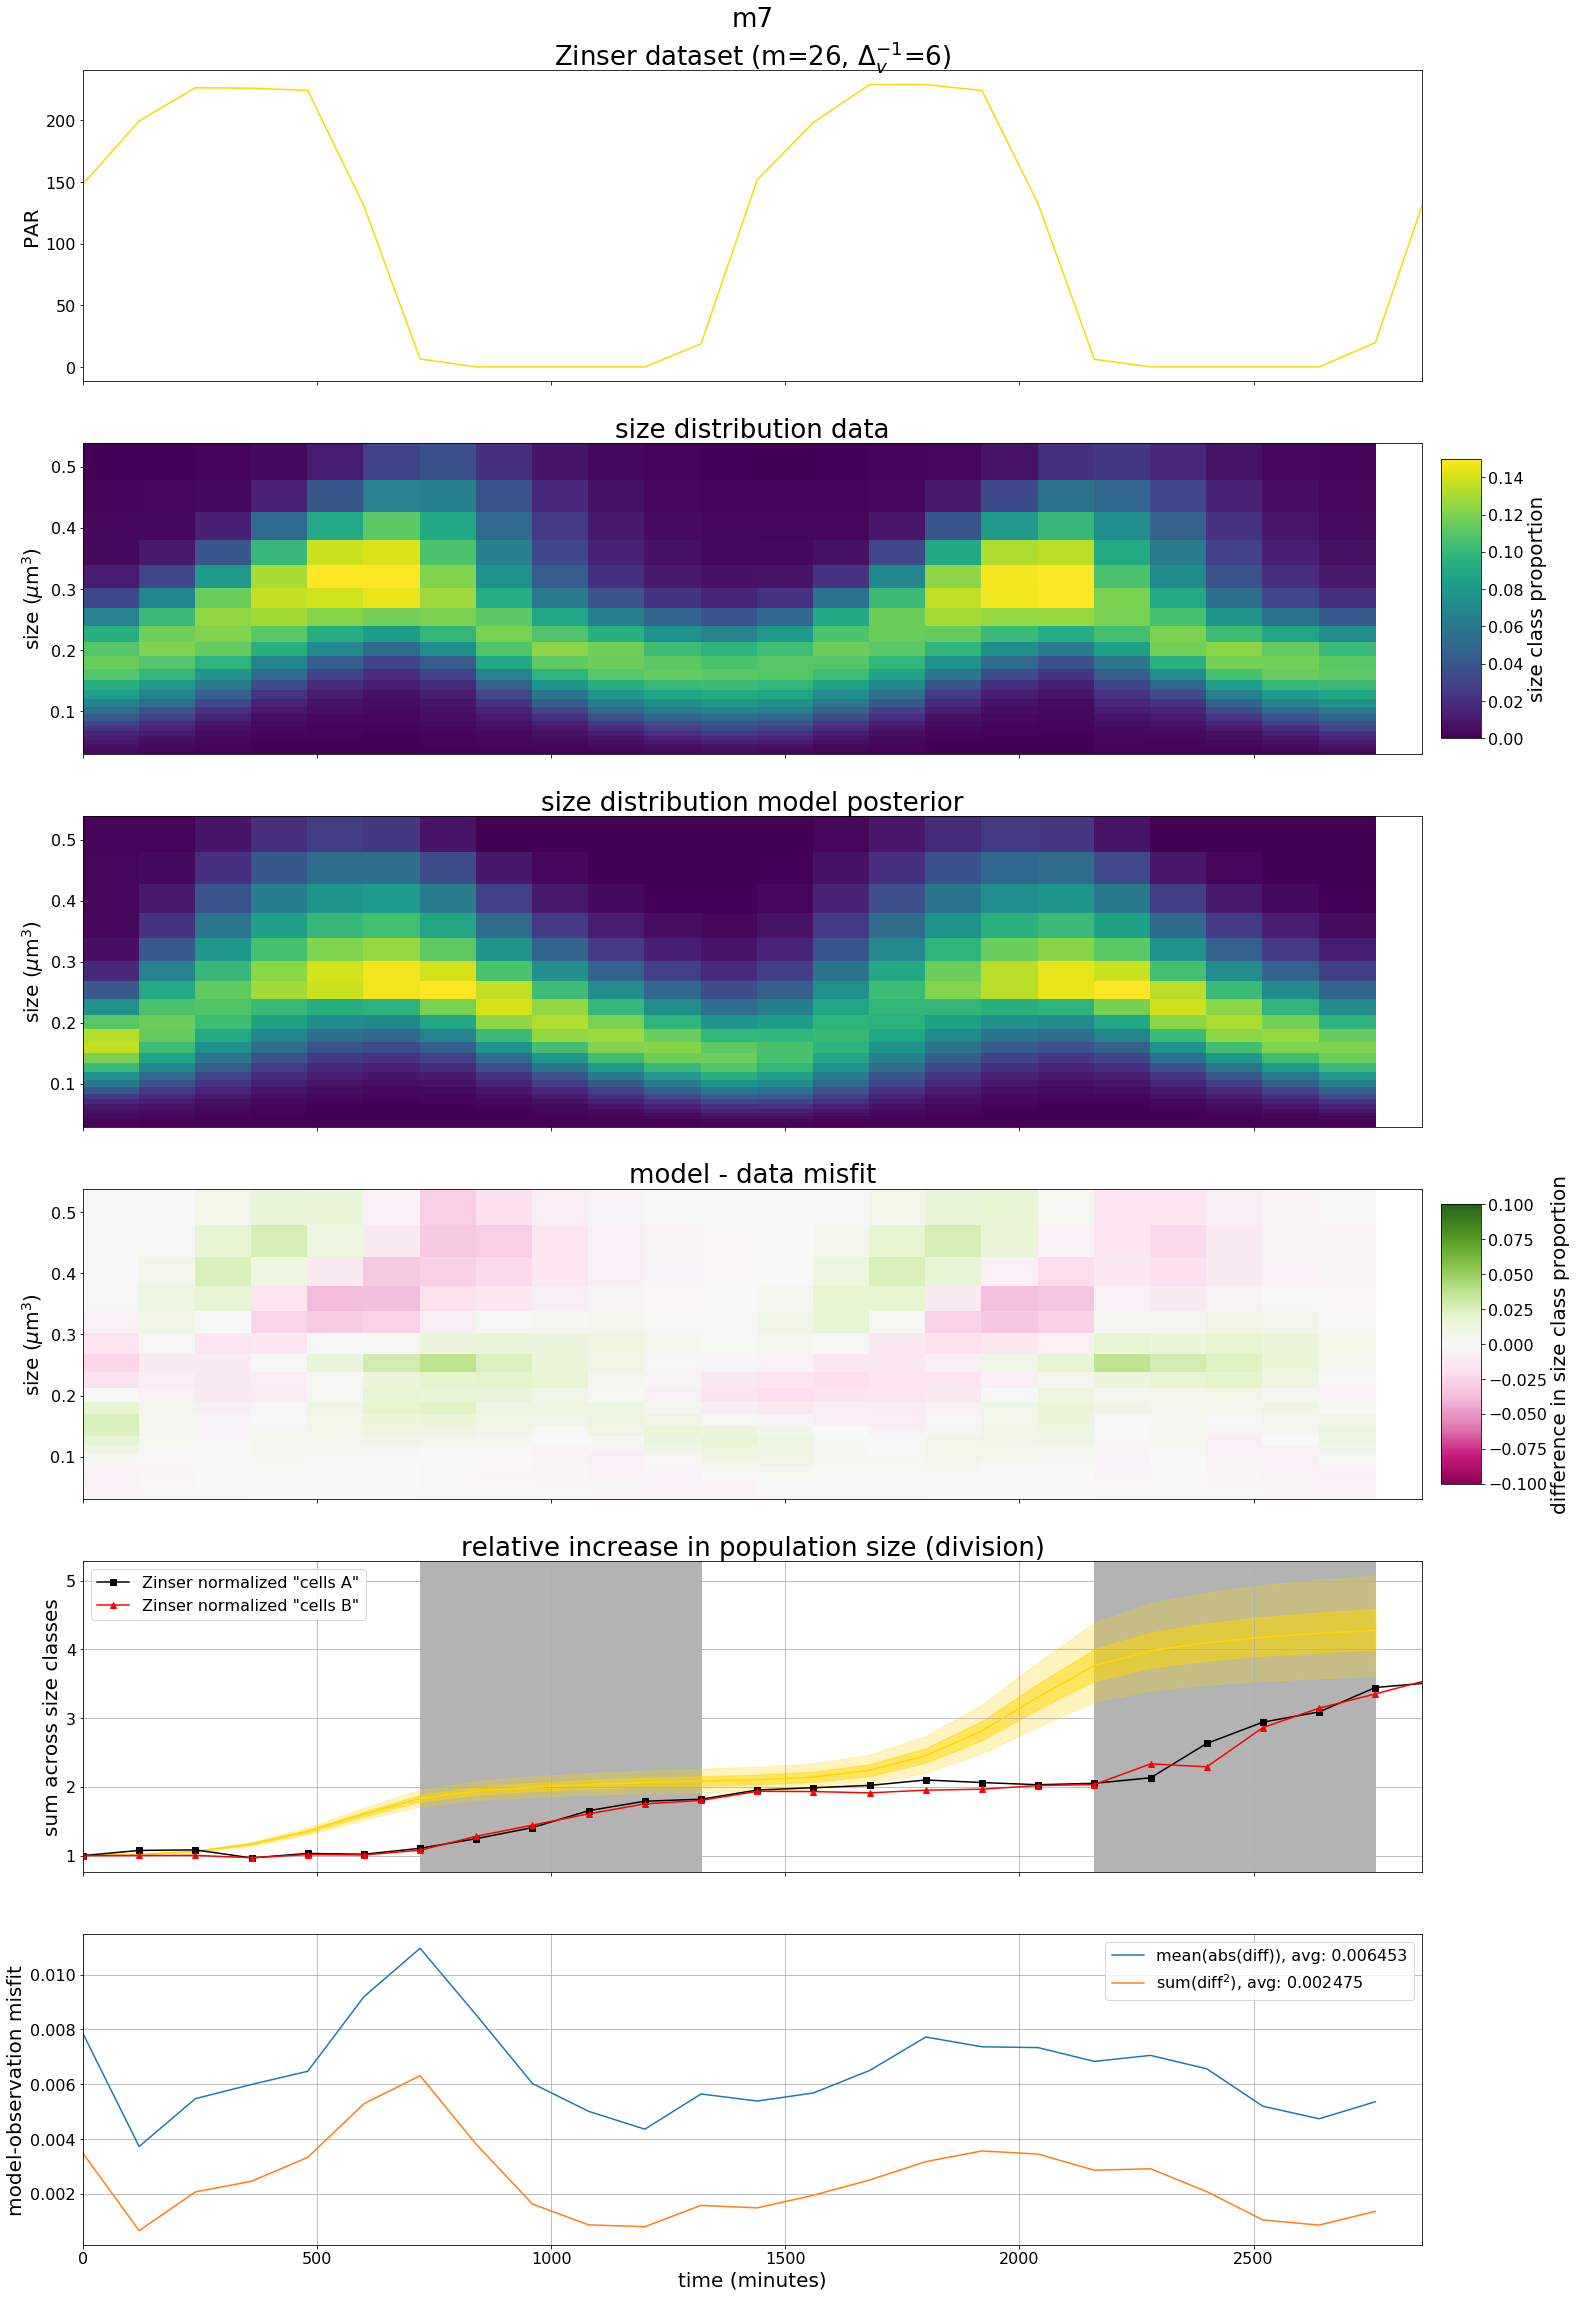

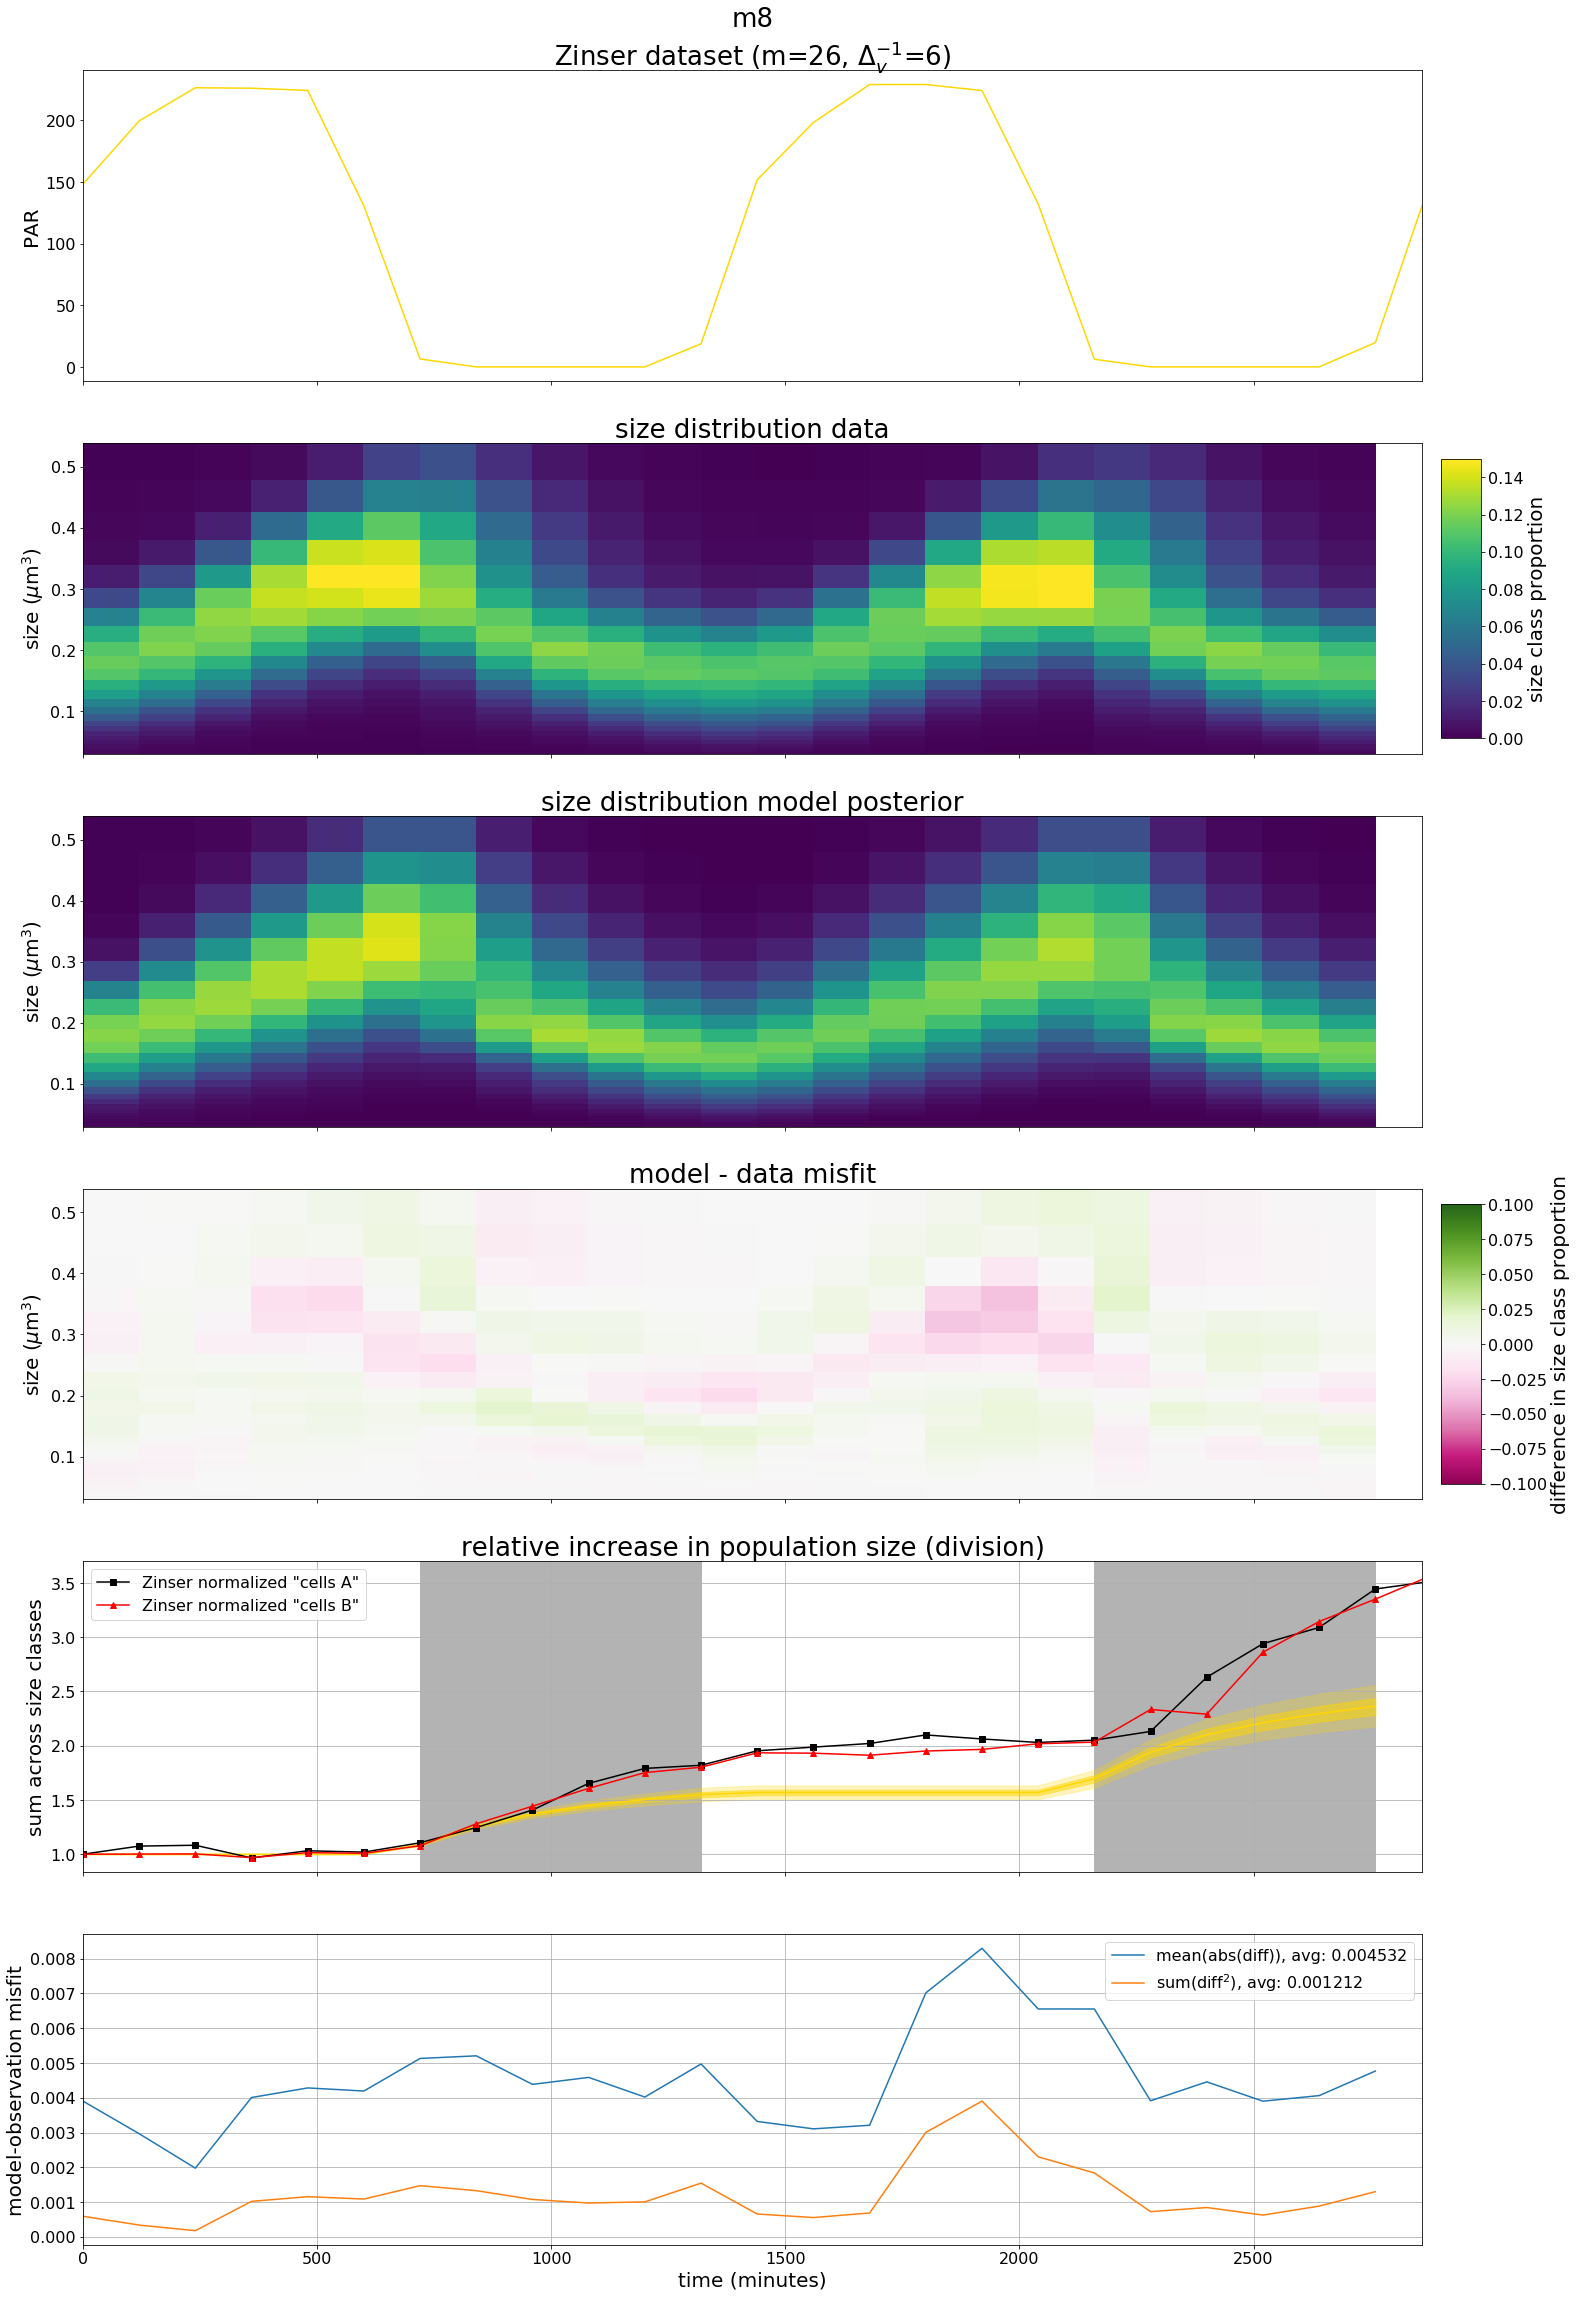

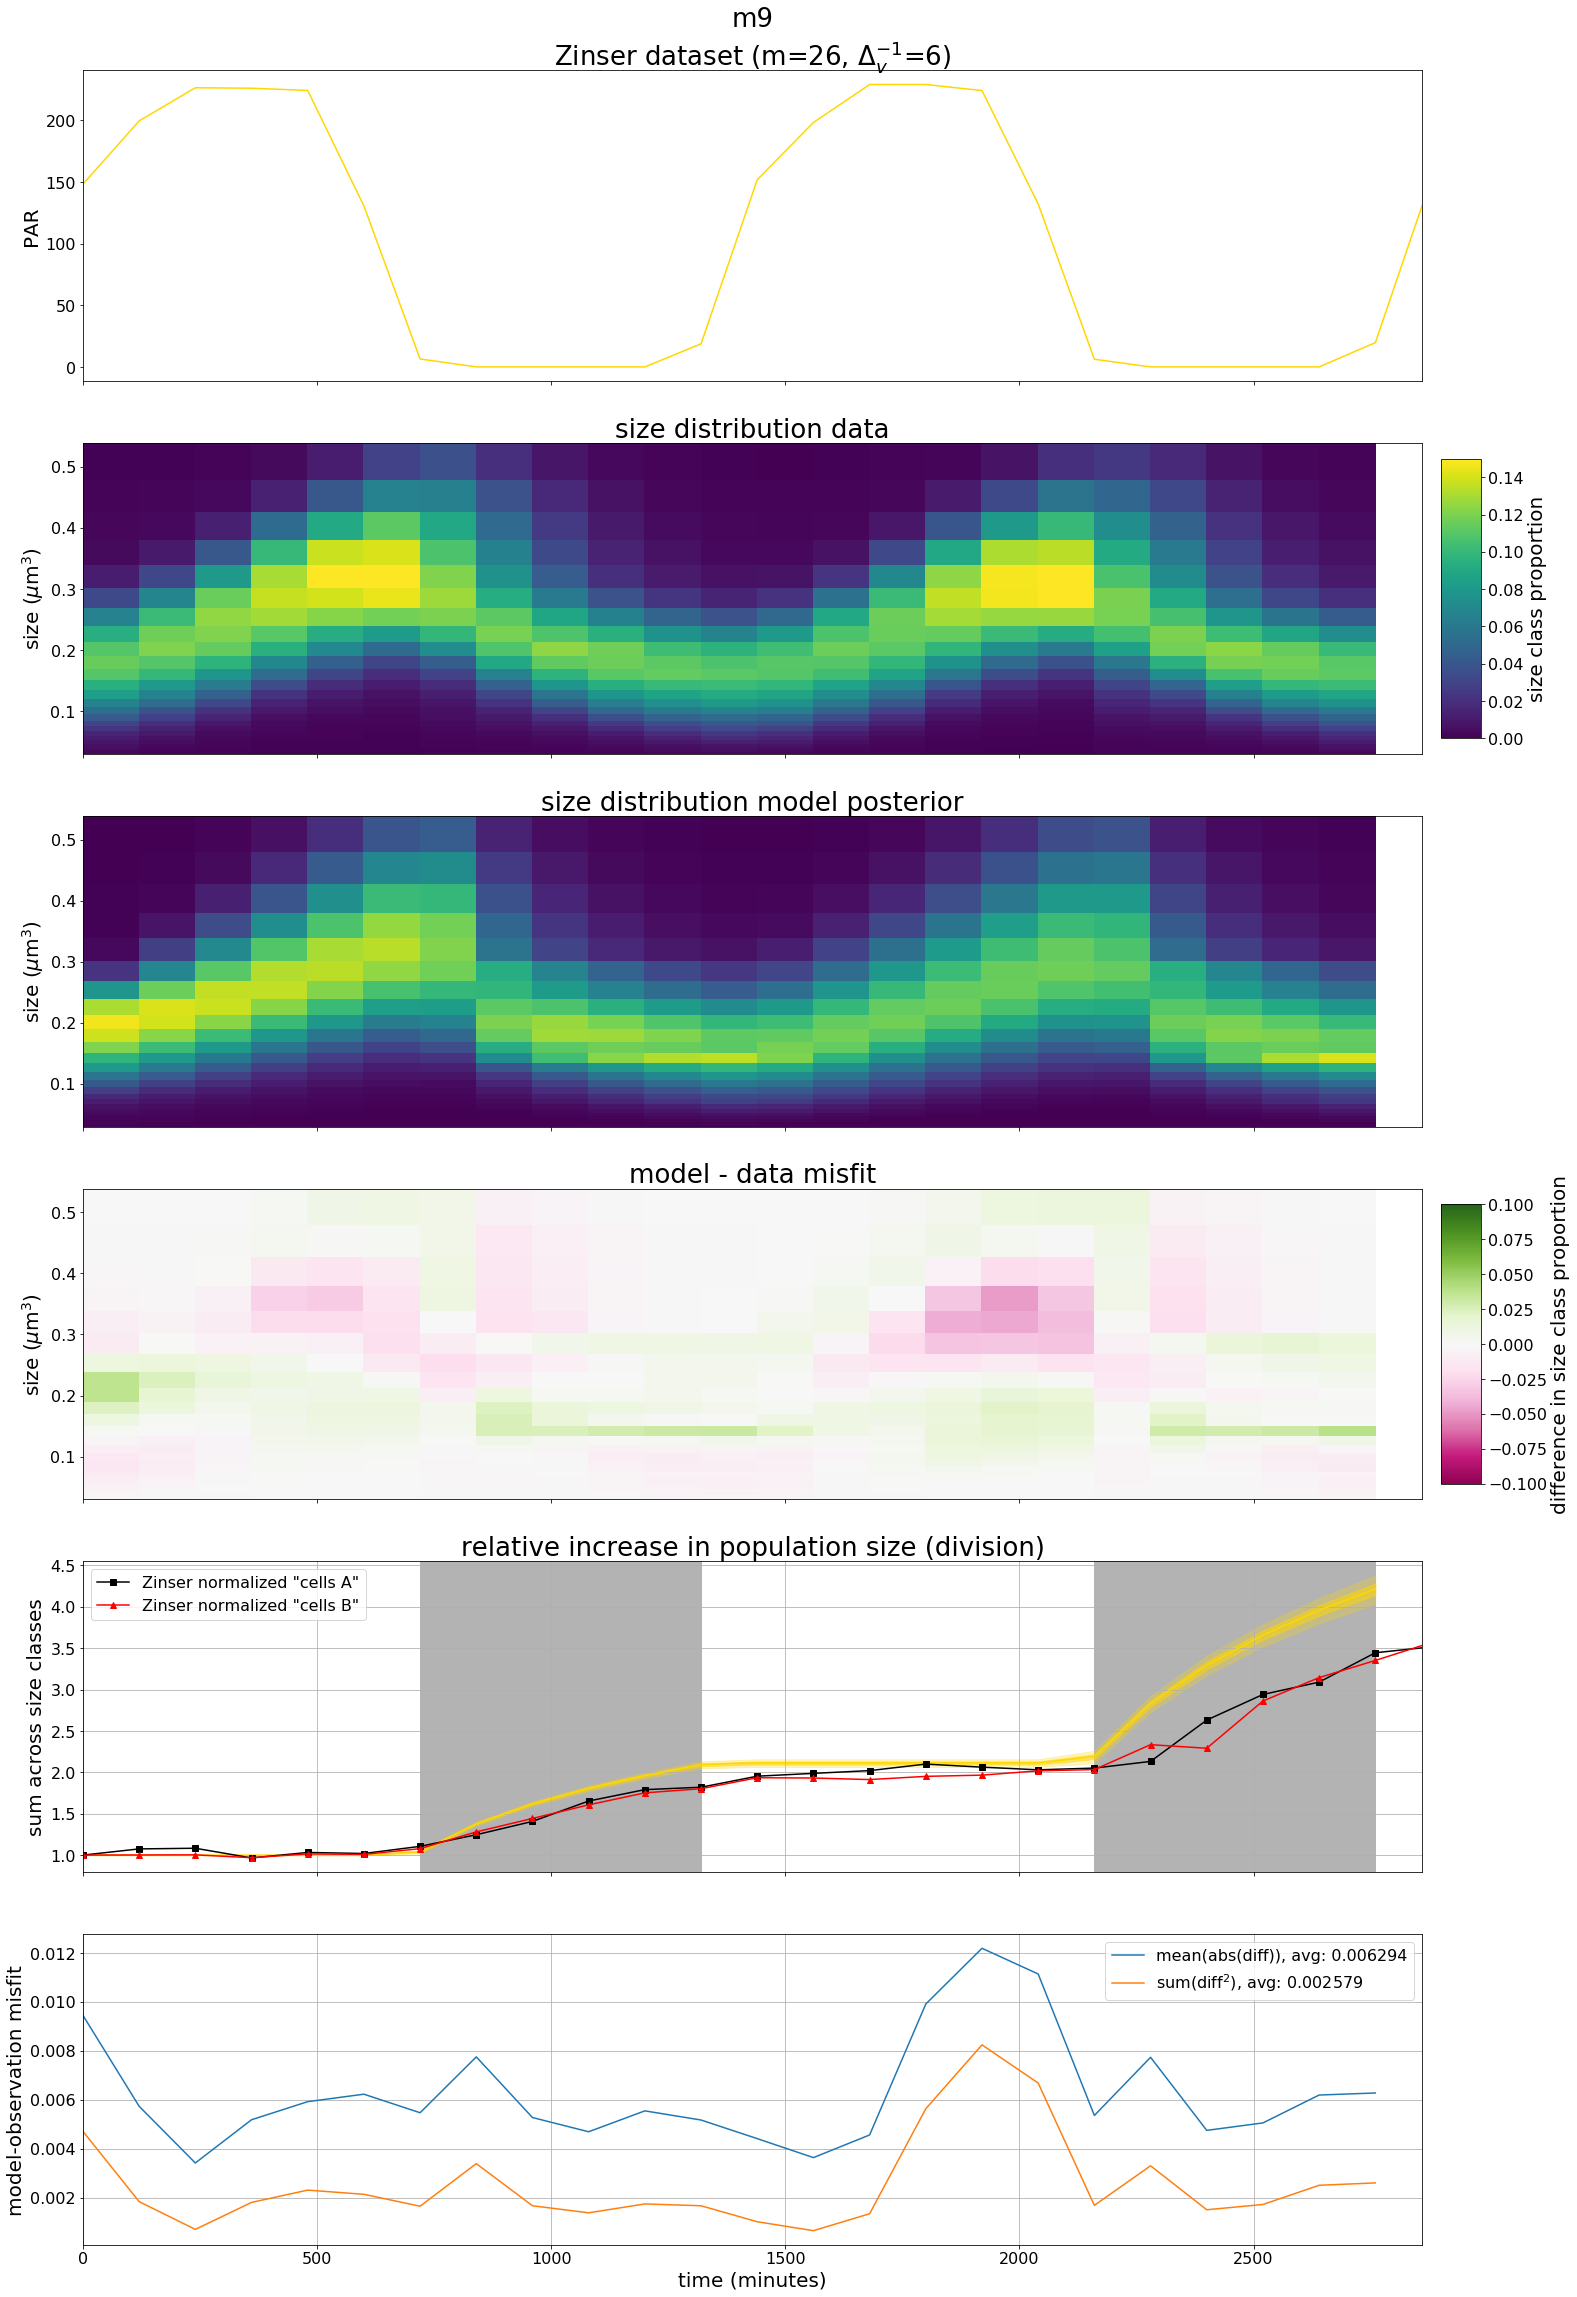

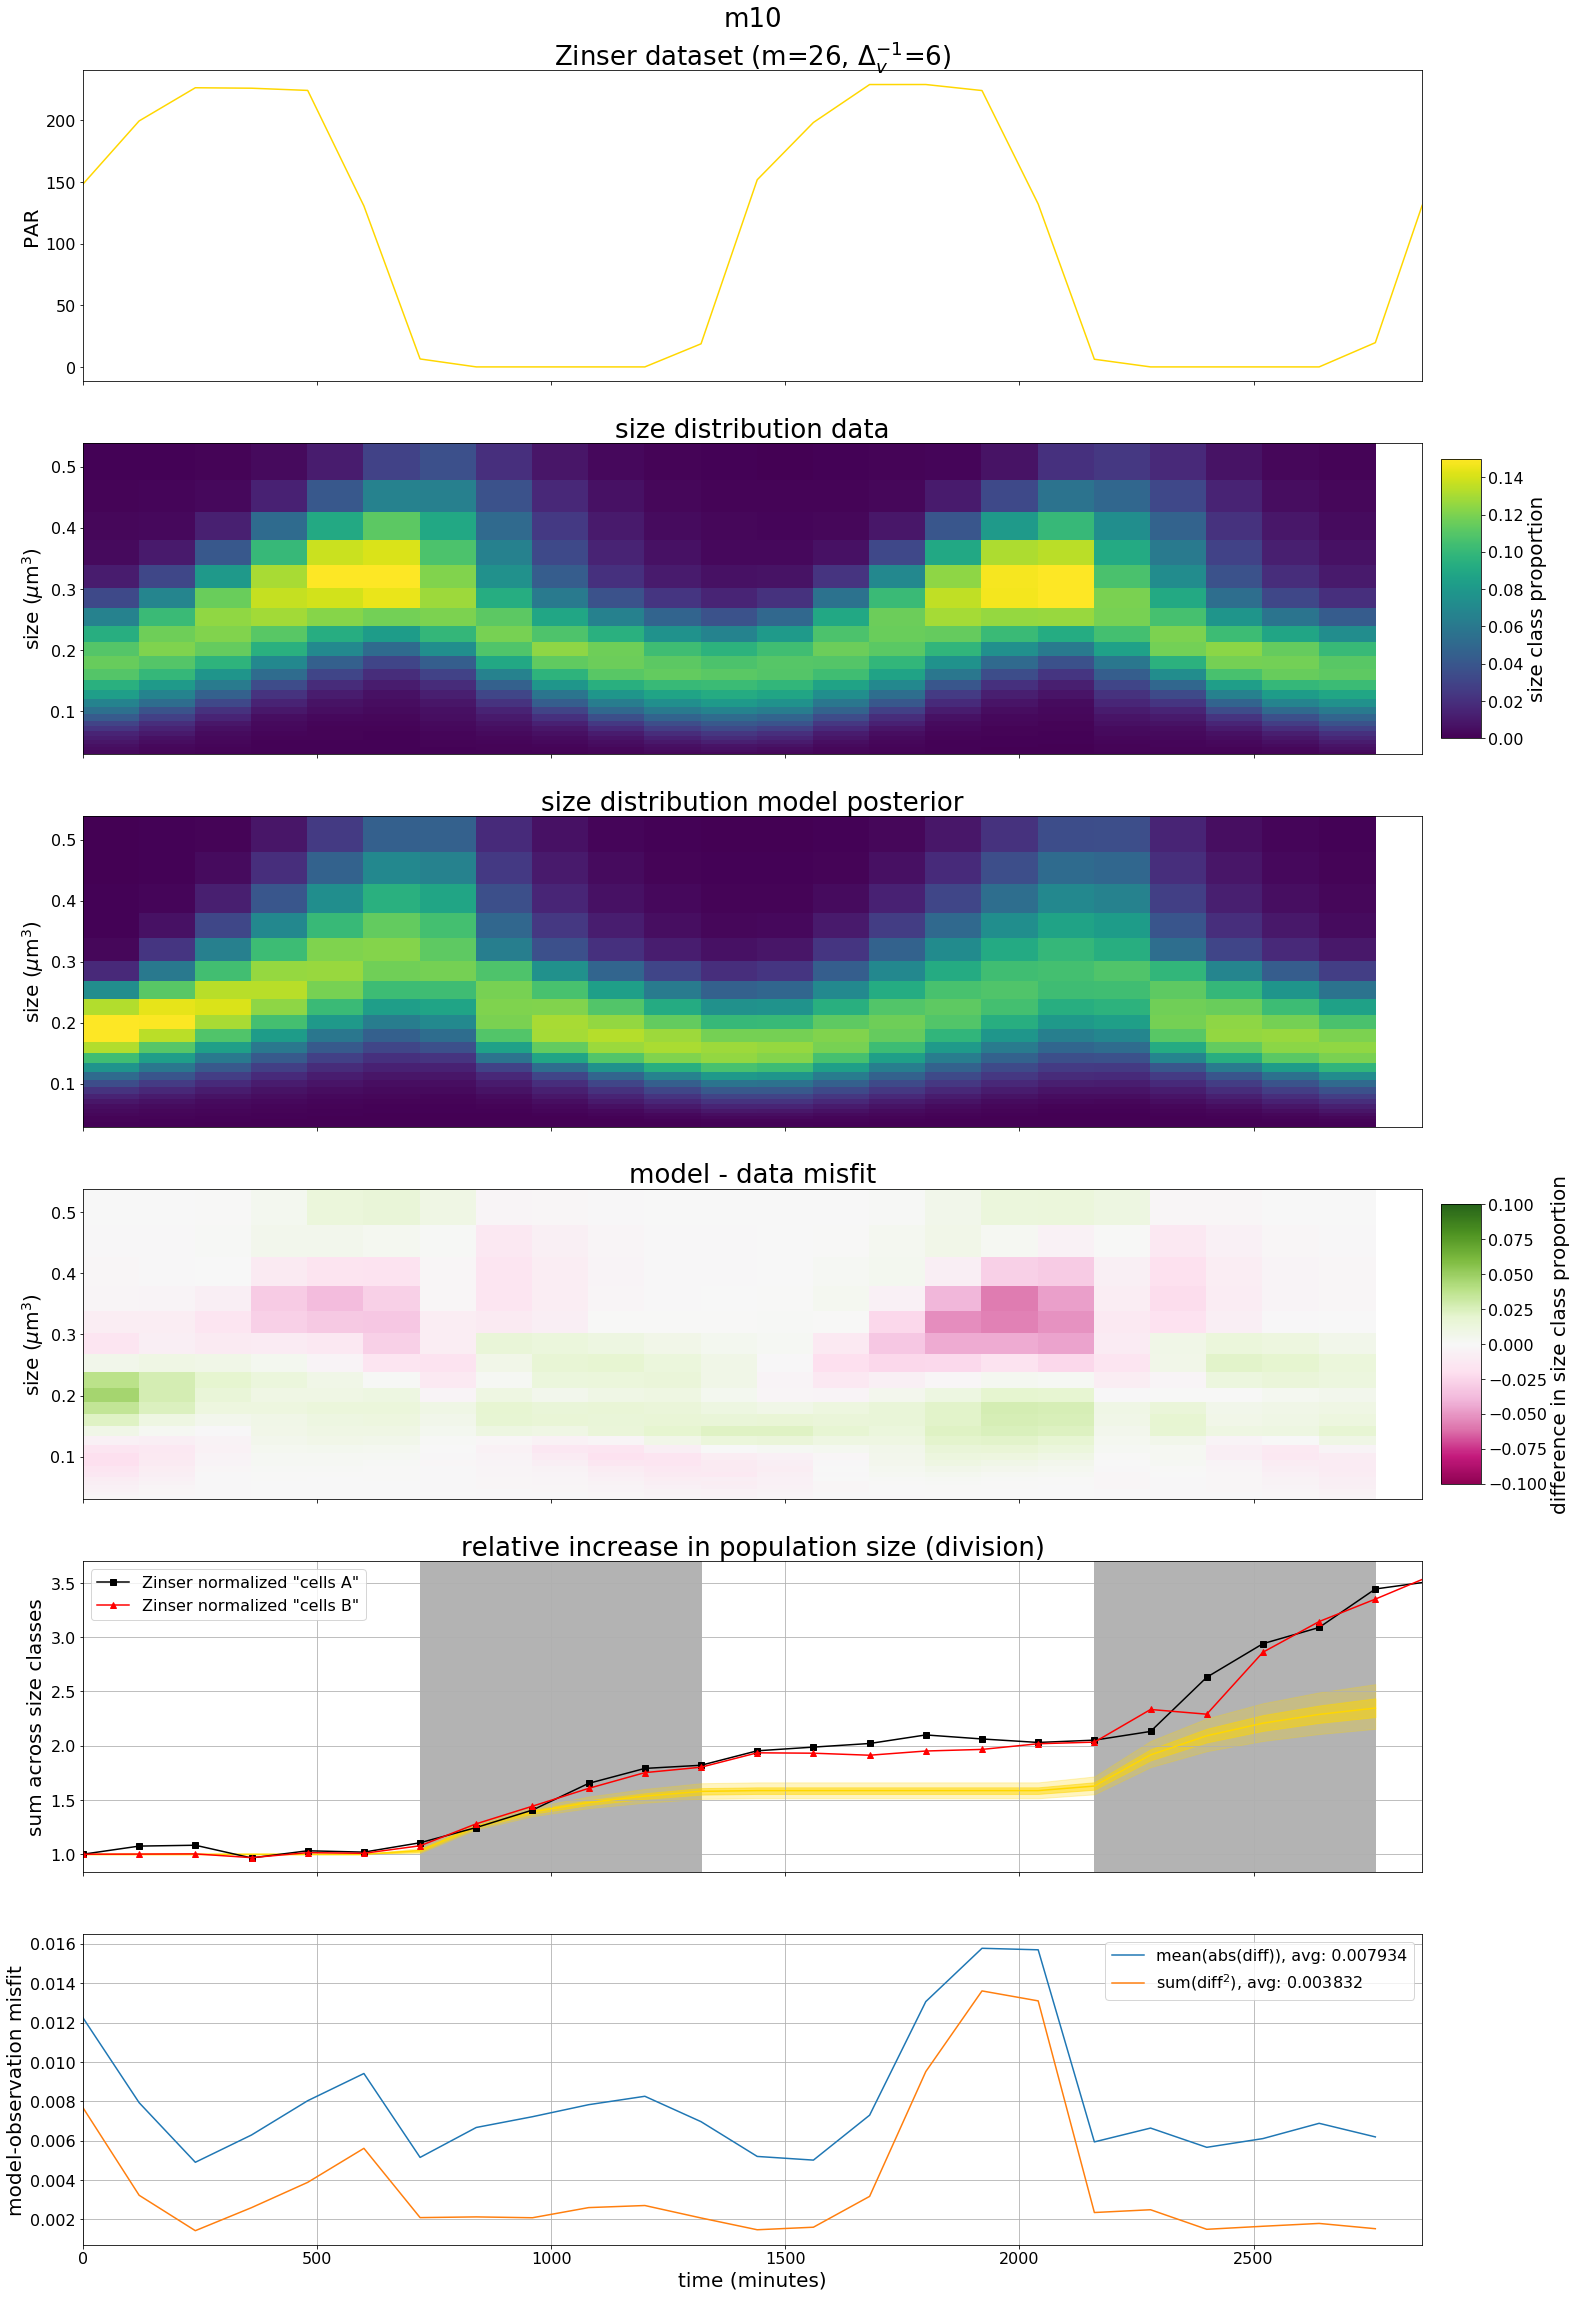

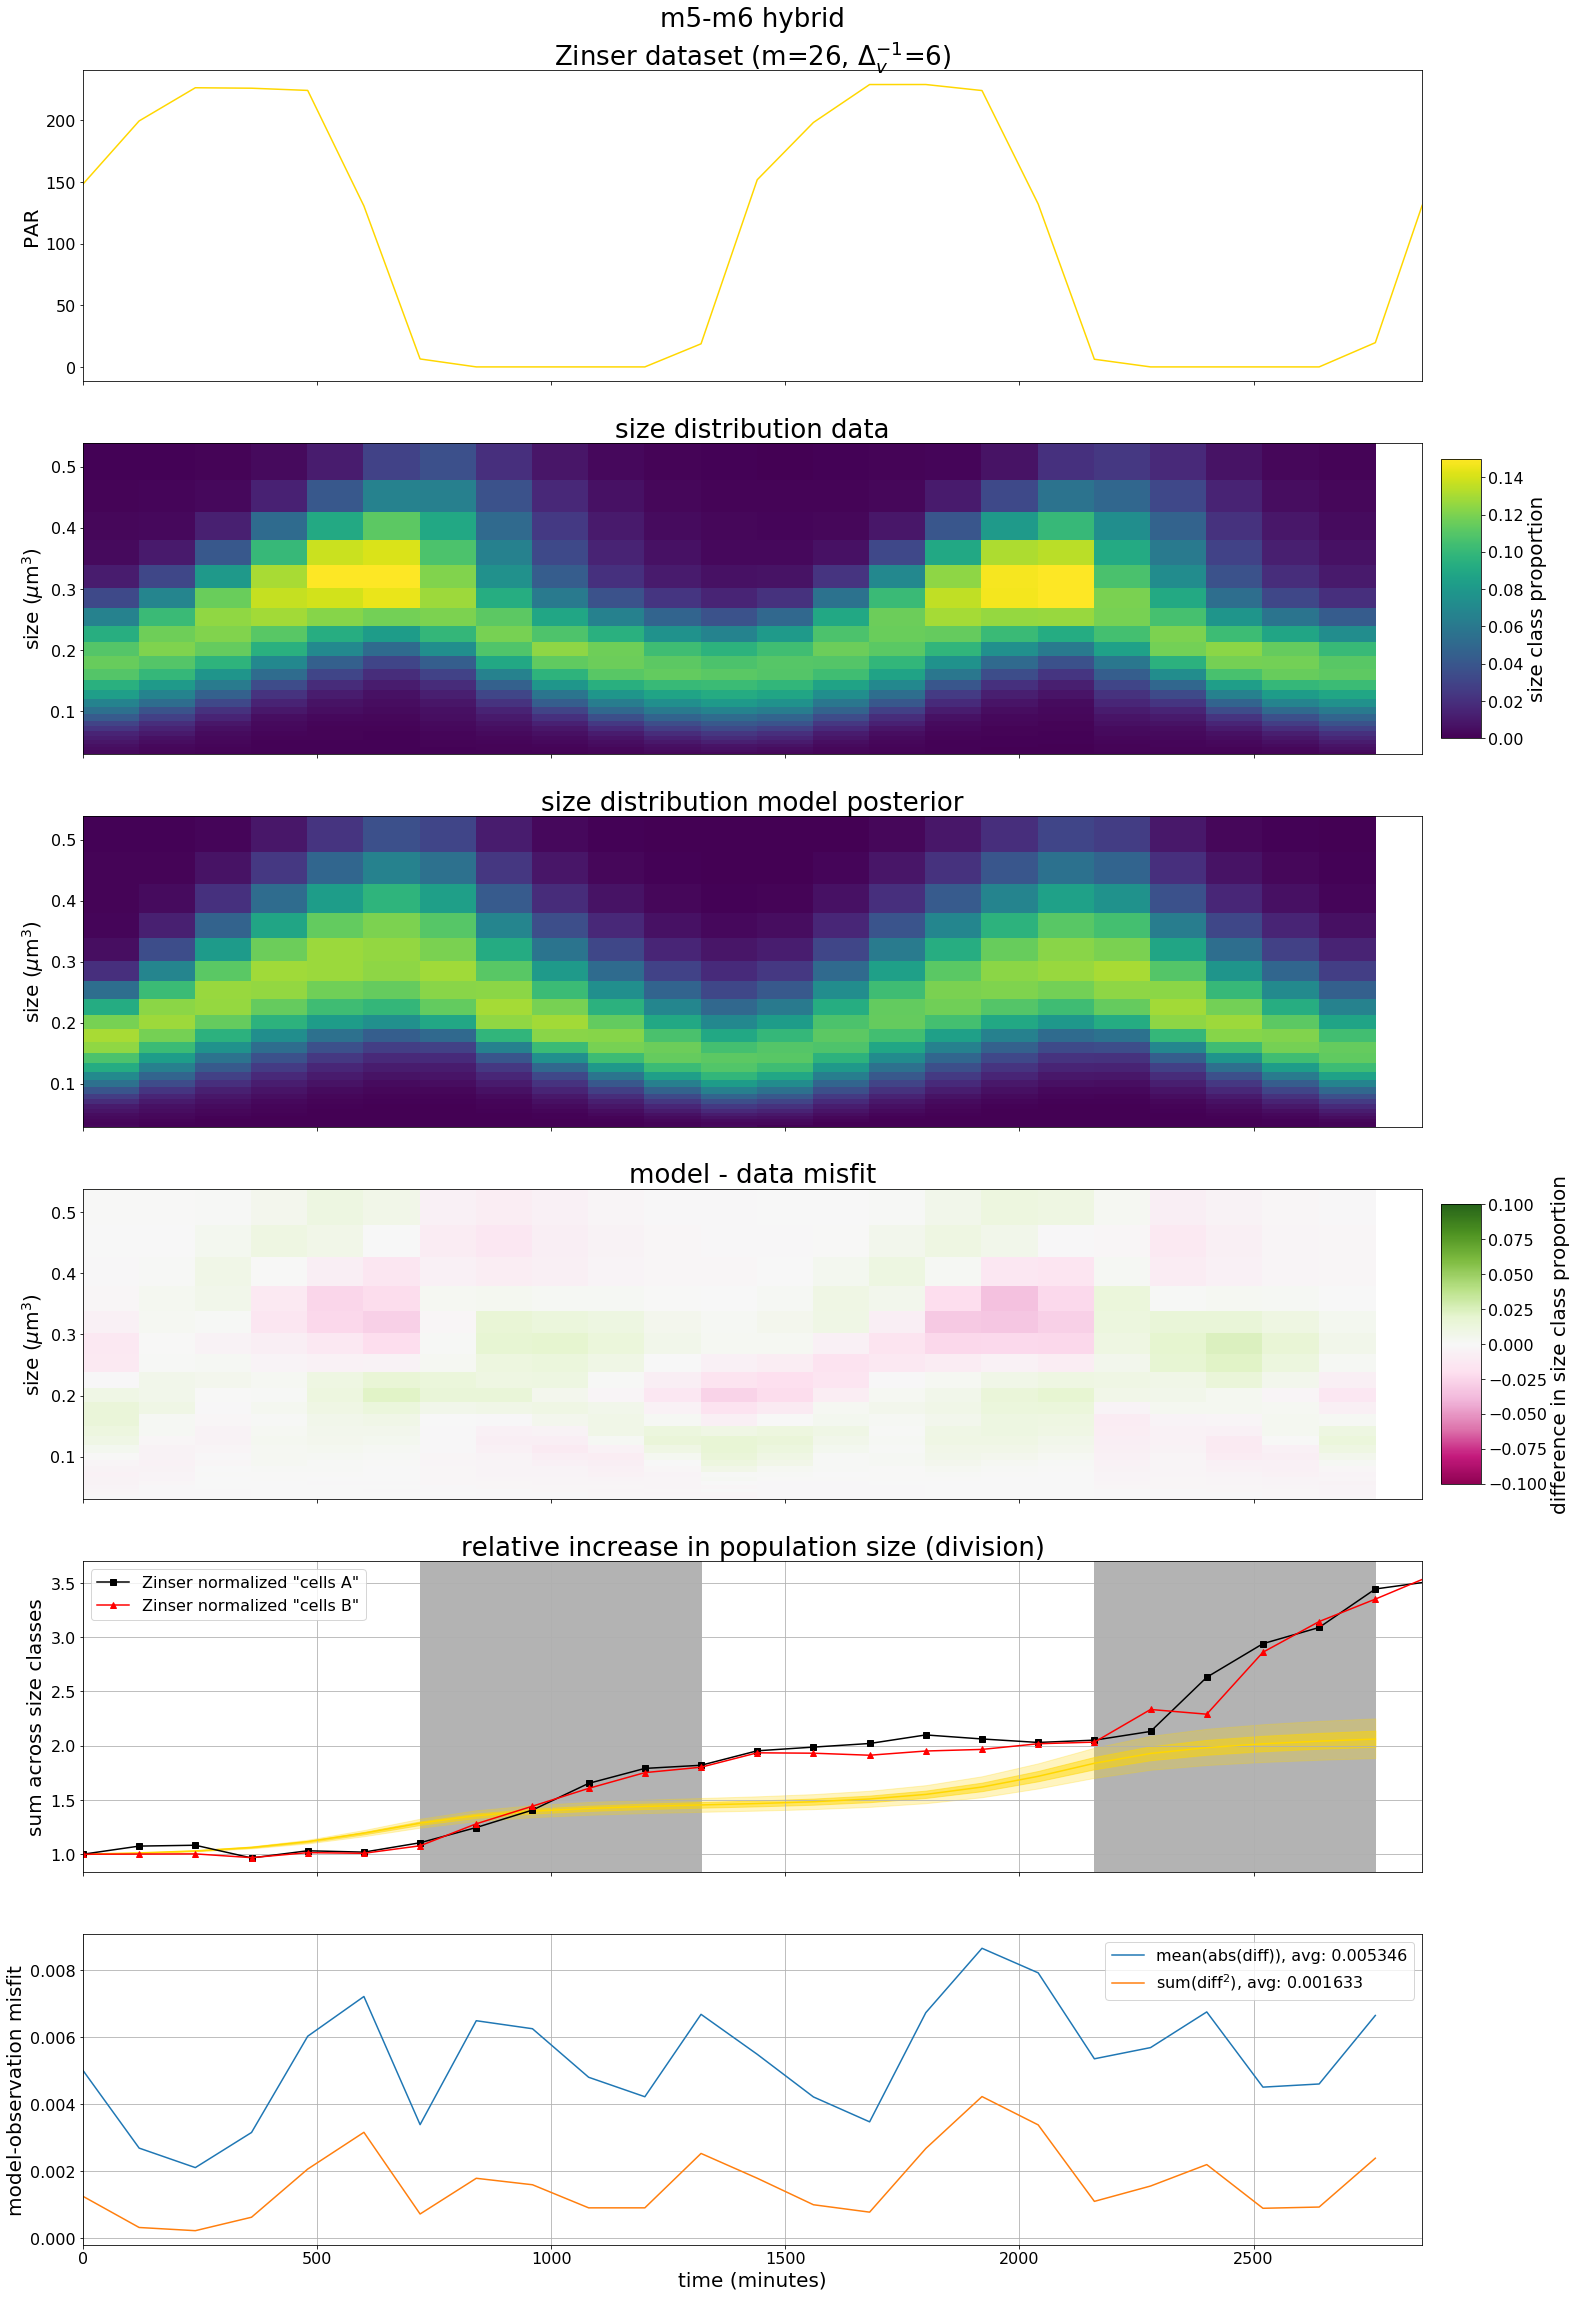

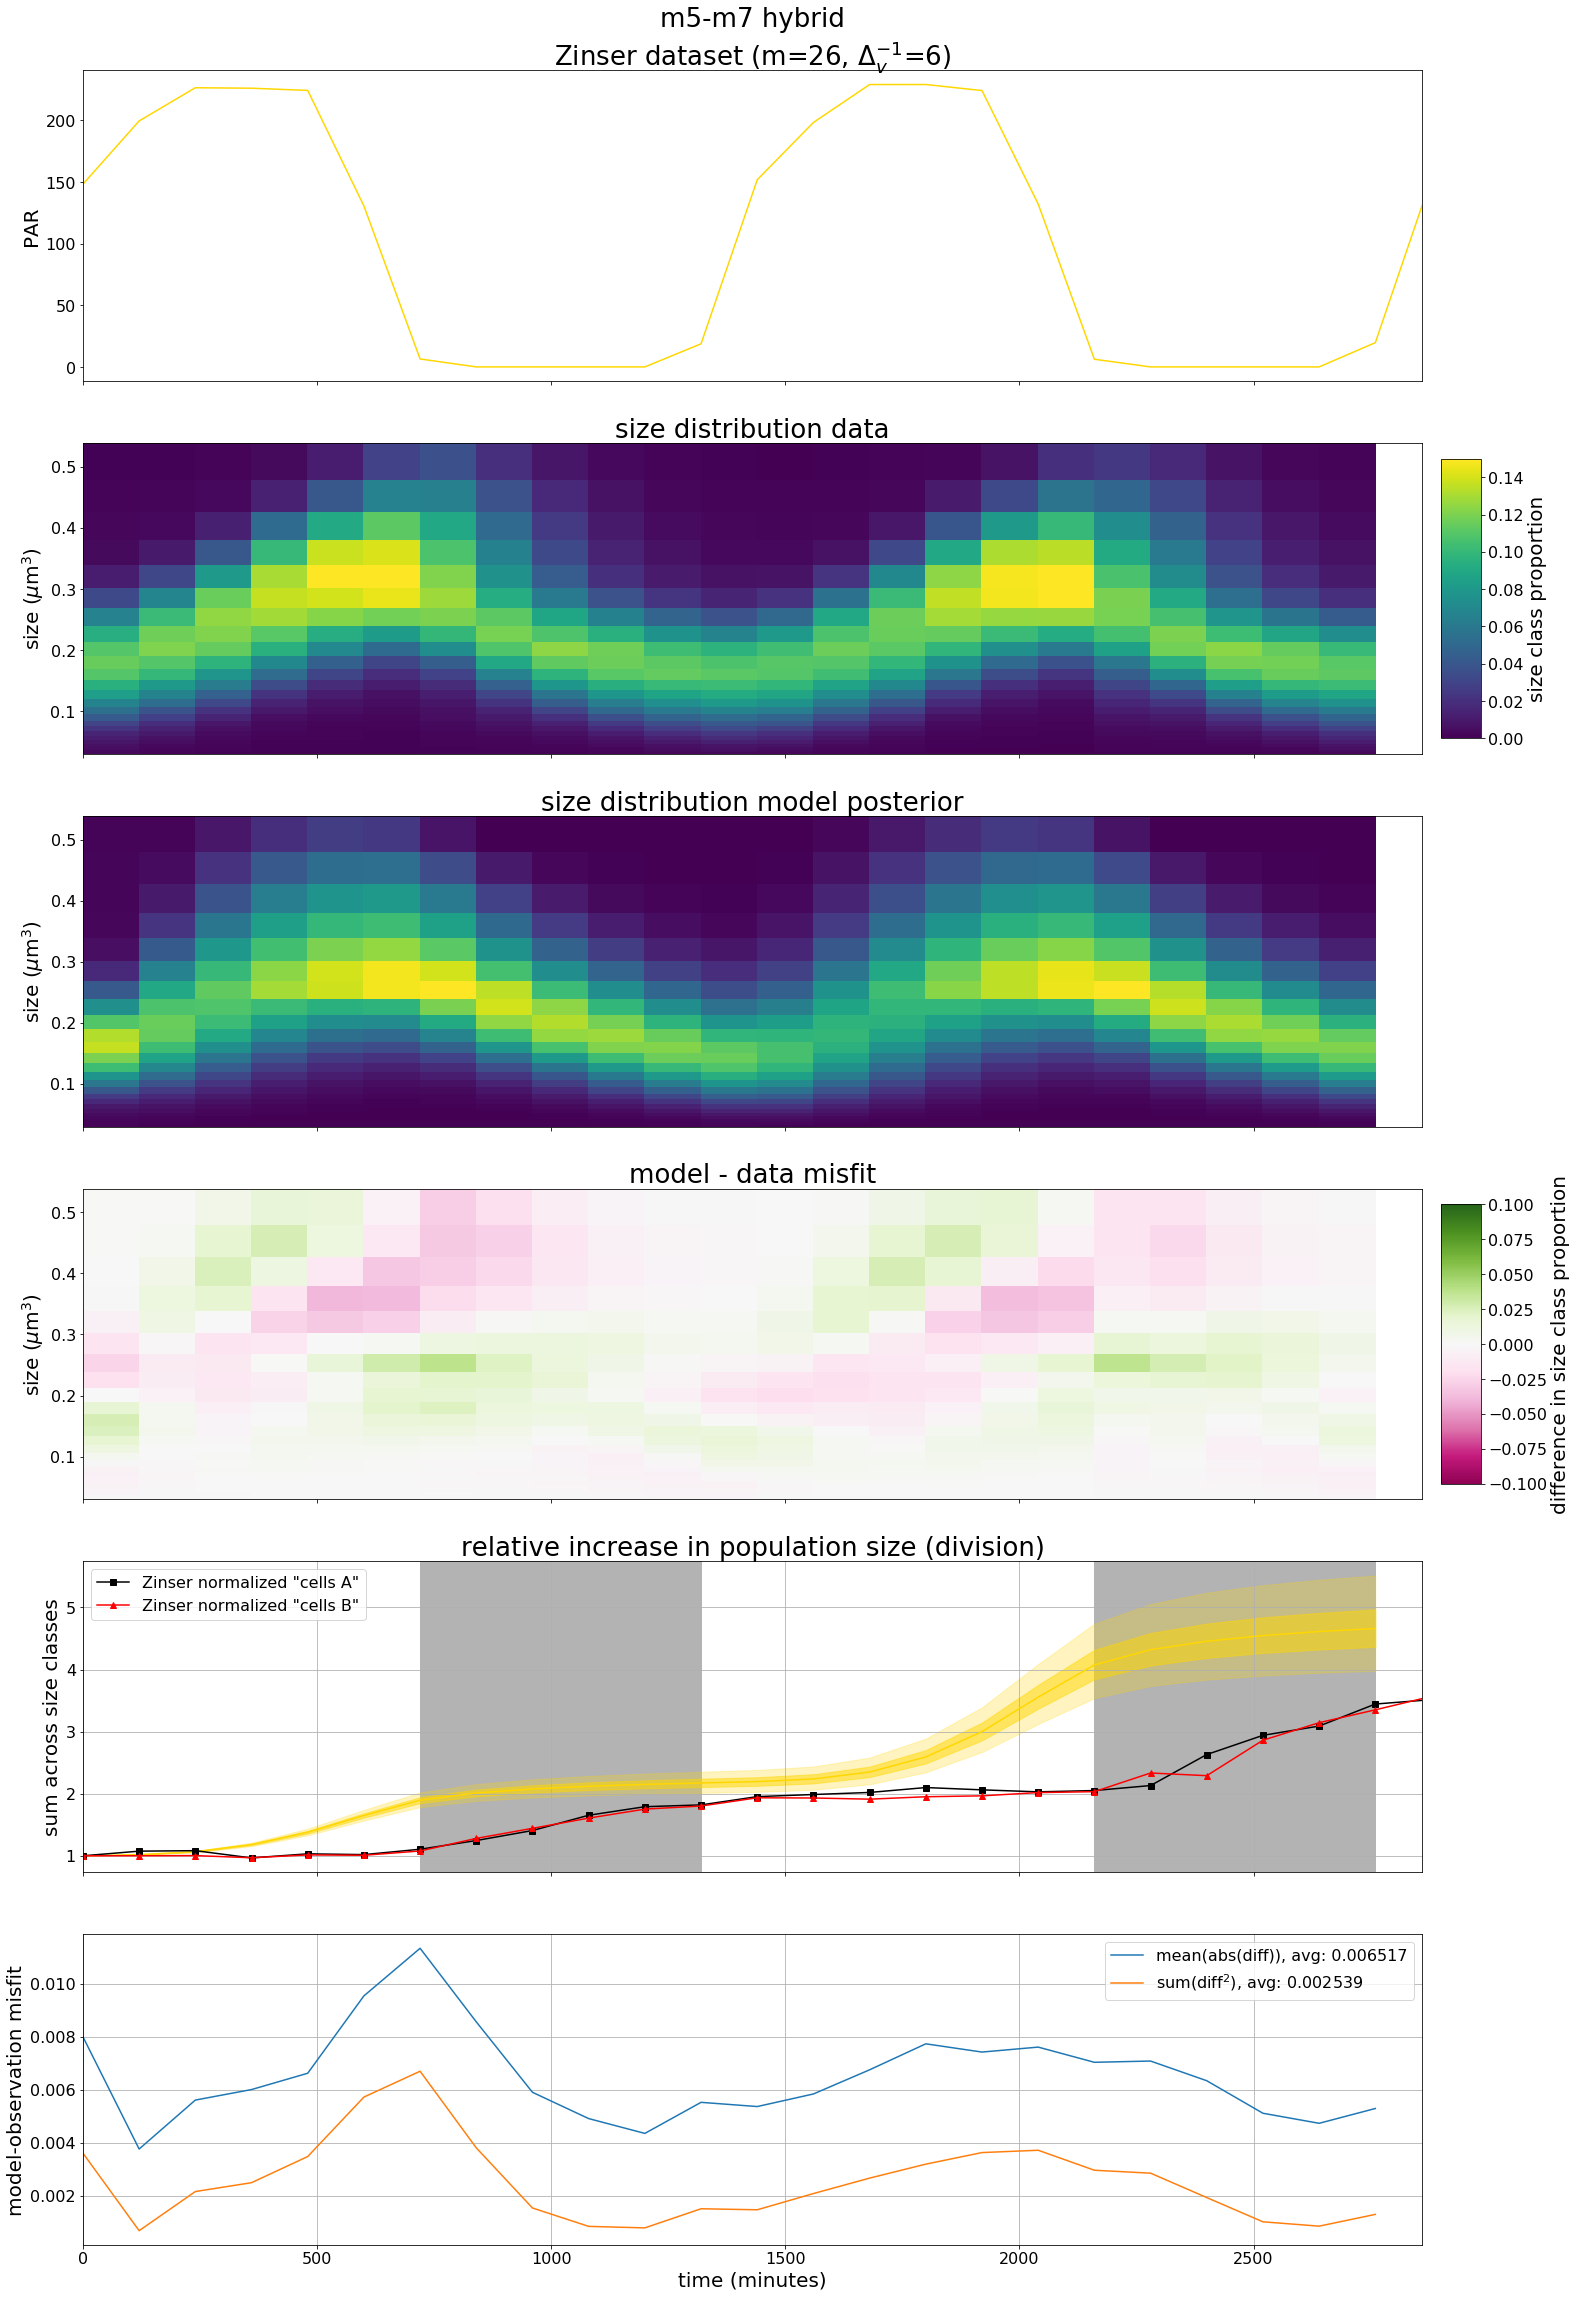

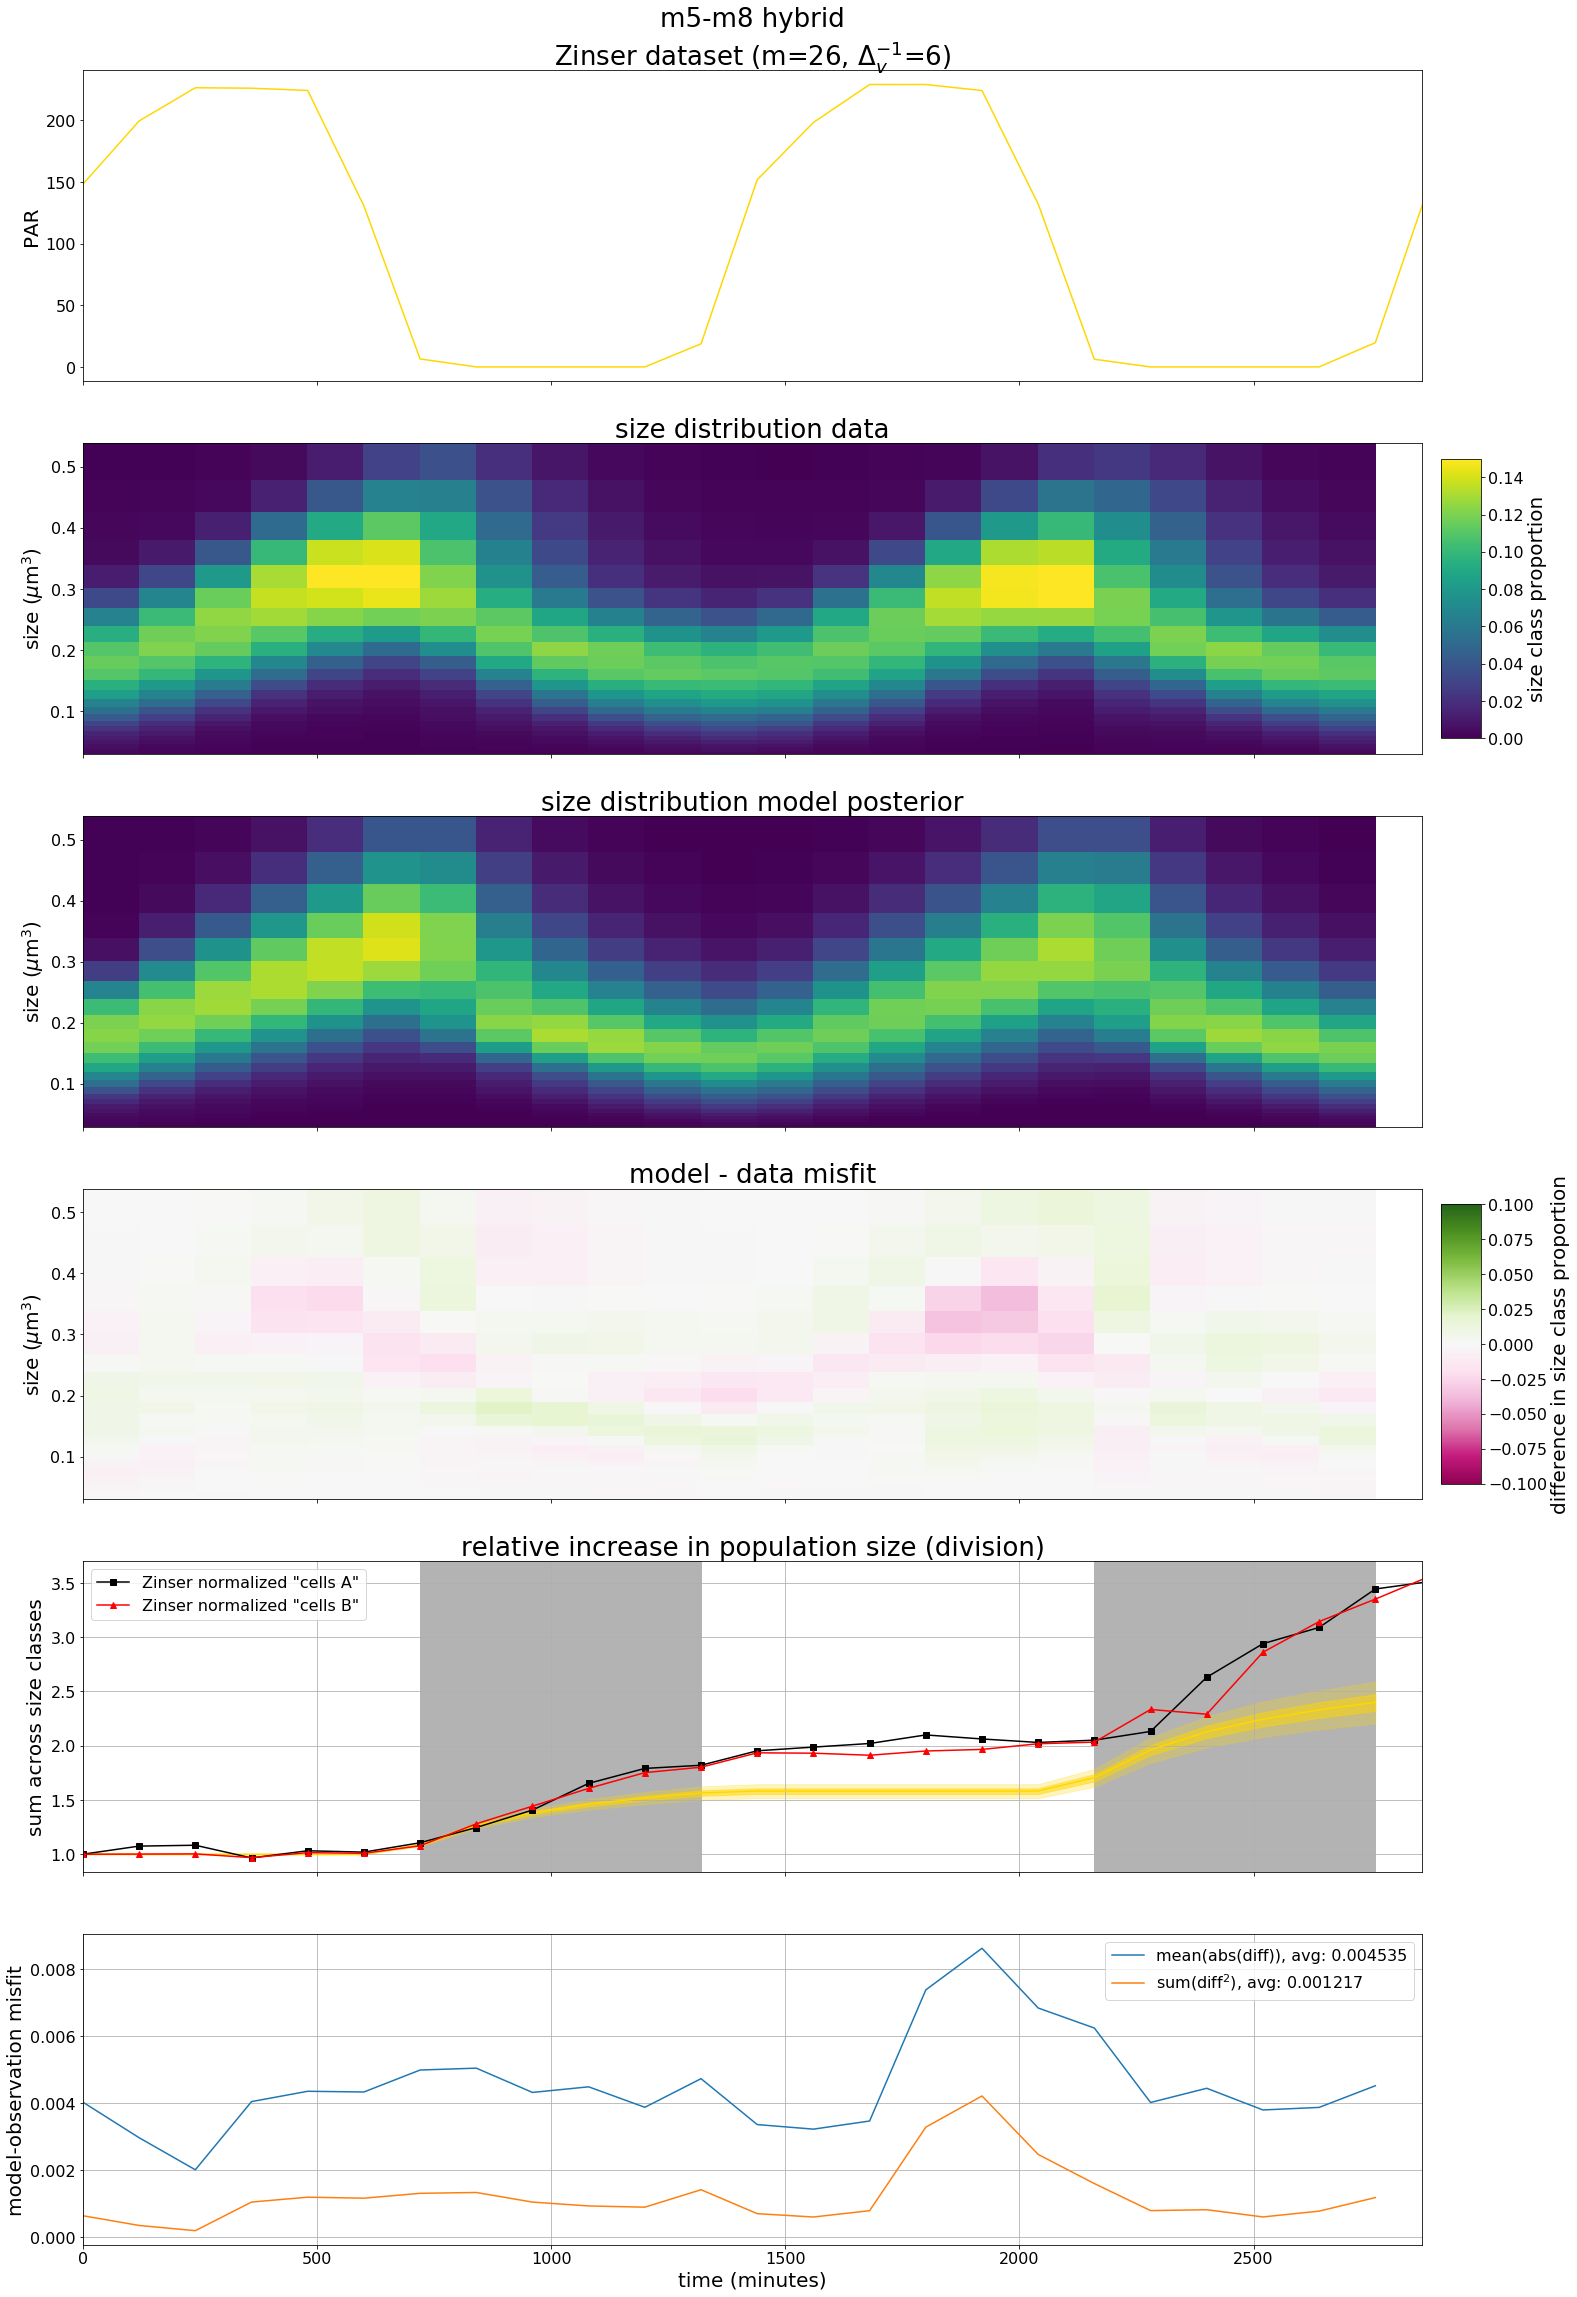

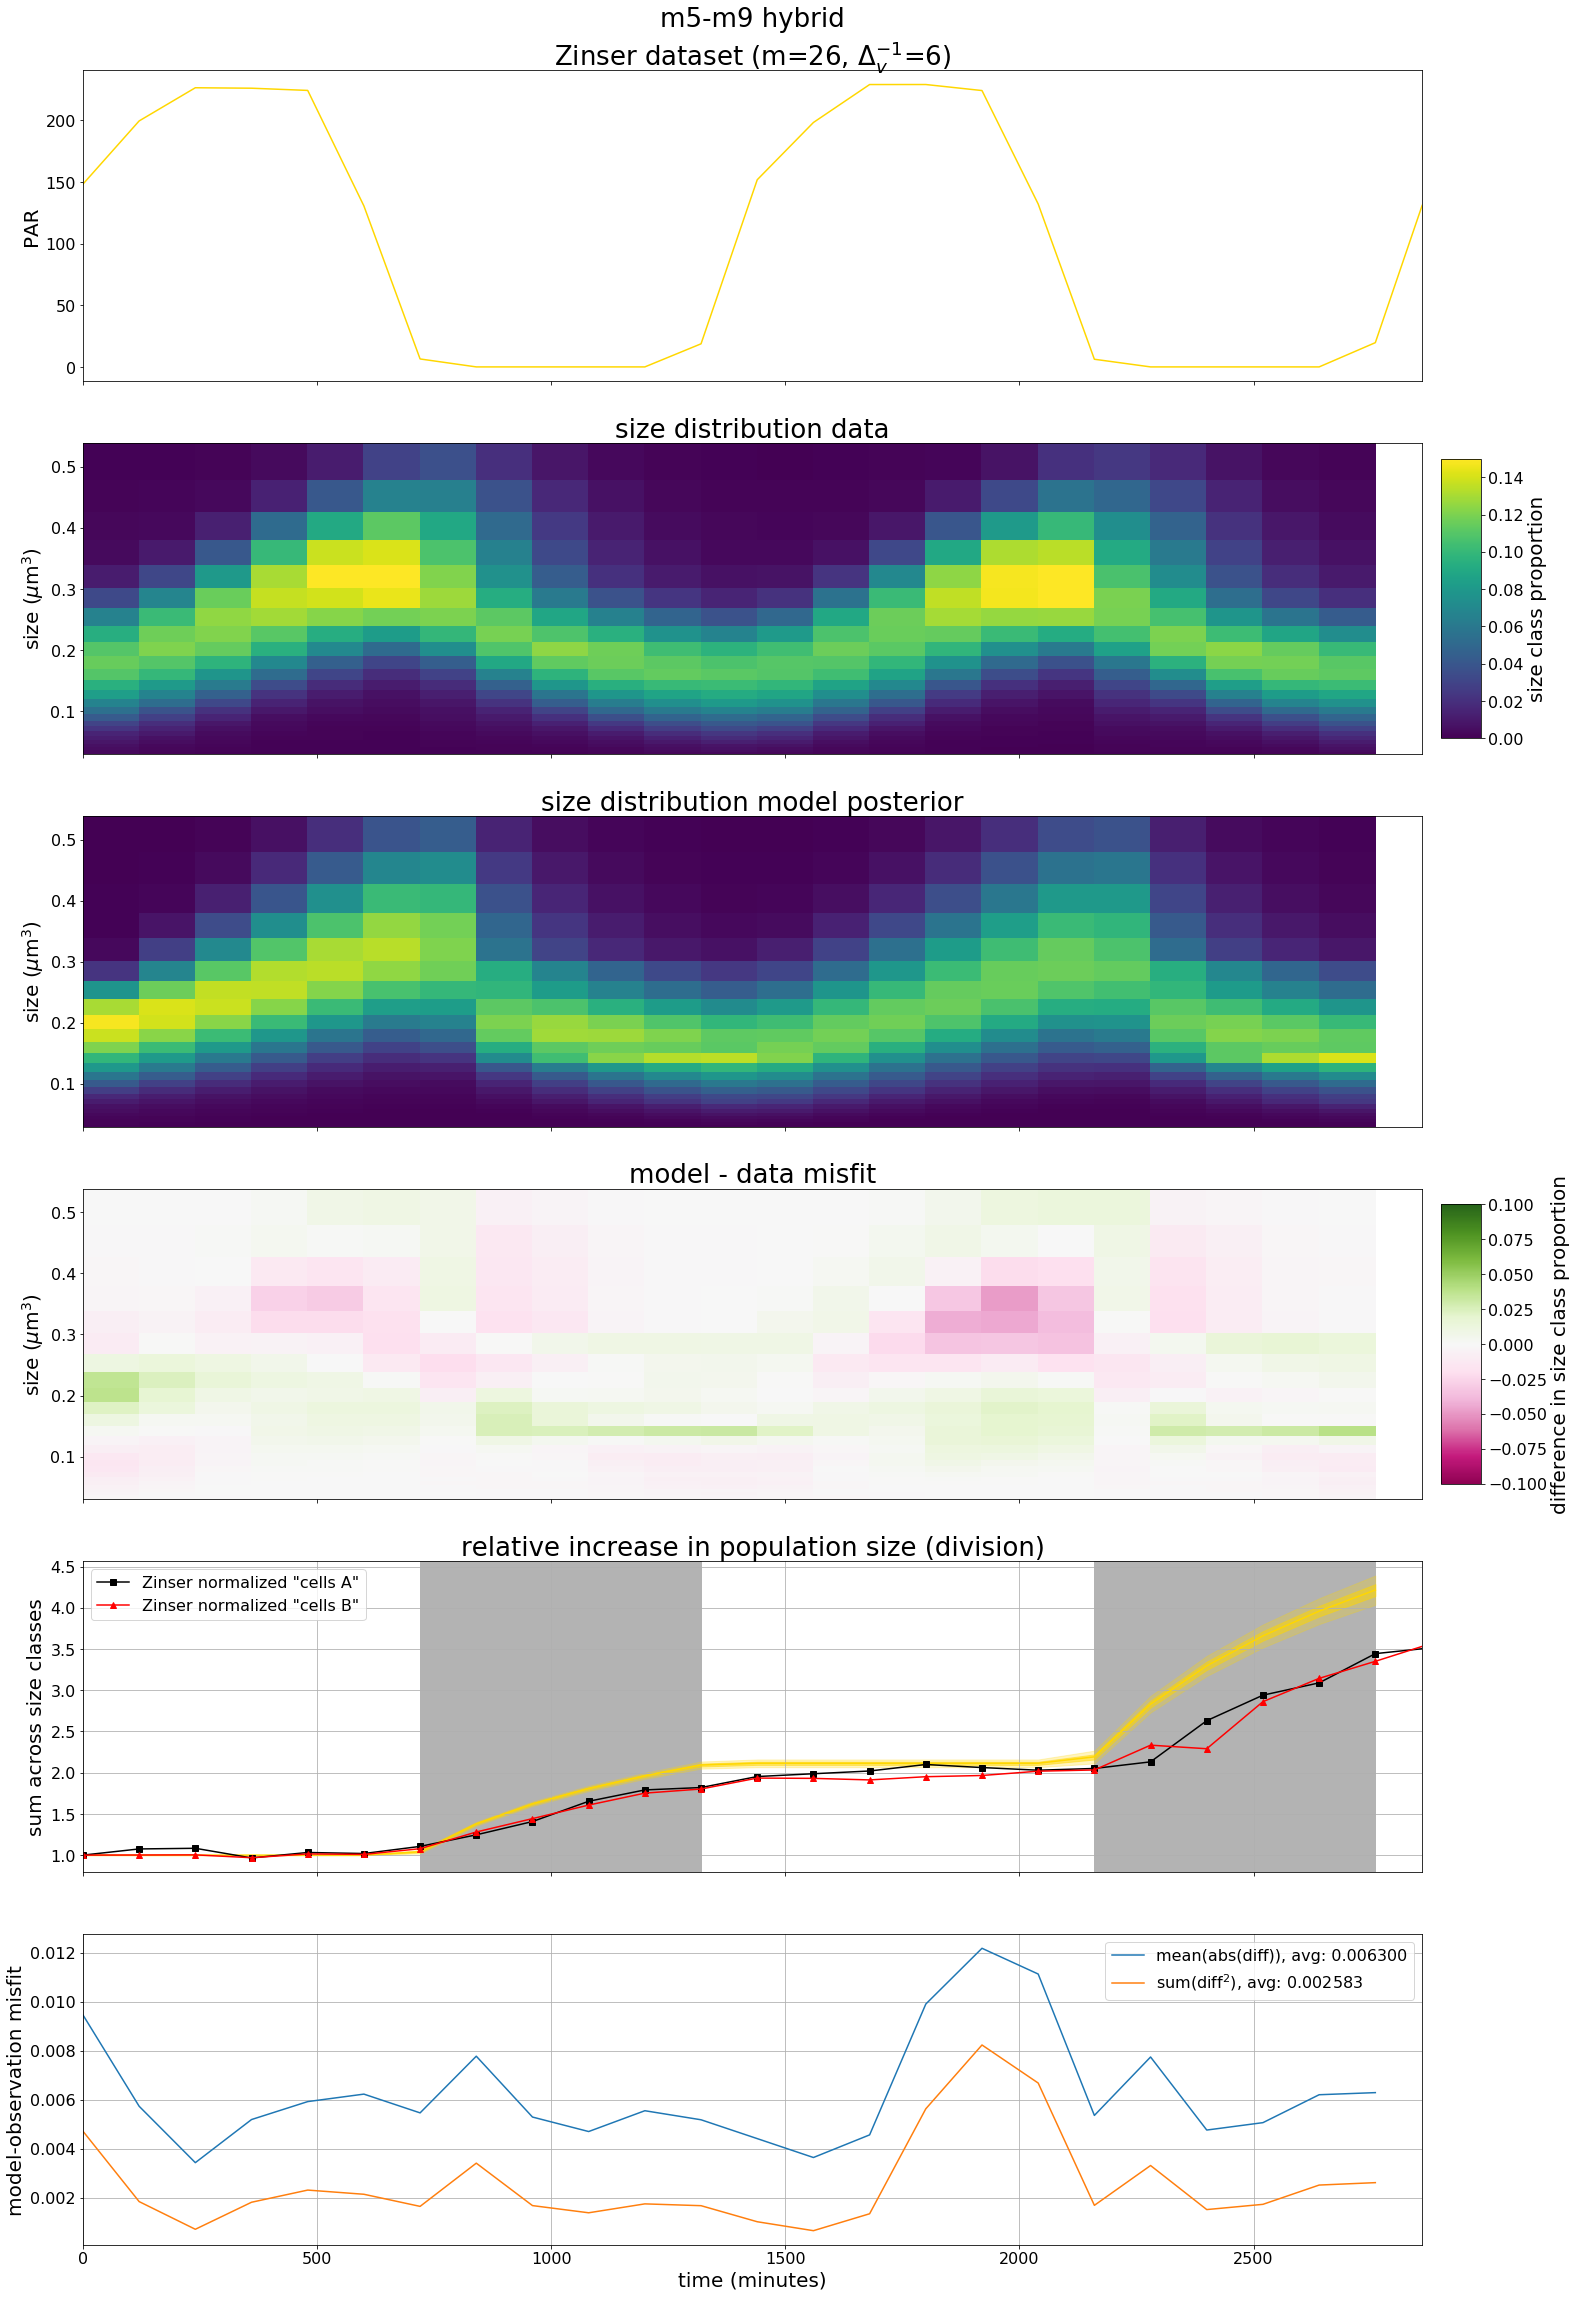

In [22]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for model,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[model][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[model] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[model] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [24]:
'''
import netCDF4 as nc4

for dataname in data:

    ncname = 'data_exp_zs_20200701_g2_ext_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,model in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                if i == 0:
                    nc.variables['sumsqdiff'].setncattr('data_used', 'all data')
            else:
                nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                if i == 0:
                    nc.variables['sumsqdiff'].setncattr('data_used', 'testing data')
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[model][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[model][dataname][v]
'''
None